In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# from tensorflow import keras
# to ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Load datasets
customers = pd.read_csv("olist_customers.csv")
geolocation = pd.read_csv('olist_geolocation.csv')
order_items = pd.read_csv('olist_order_items.csv')
payments = pd.read_csv('olist_payments.csv')
reviews = pd.read_csv('olist_reviews.csv')
orders = pd.read_csv('olist_orders.csv')
products = pd.read_csv('olist_products.csv')
sellers = pd.read_csv('olist_sellers.csv')

In [2]:
# Objective: Customer segemention (Behavioural segmentation), Customer Purchase Behaviour Analysis

In [3]:
df_cus_seg= pd.merge(customers, orders, on="customer_id", how='inner')
df_cus_seg= df_cus_seg.merge(reviews, on="order_id", how='inner')
df_cus_seg= df_cus_seg.merge(order_items, on="order_id", how='inner')
df_cus_seg= df_cus_seg.merge(products, on="product_id", how='inner')
df_cus_seg= df_cus_seg.merge(payments, on="order_id", how='inner')
df_cus_seg= df_cus_seg.merge(sellers, on='seller_id', how='inner')
df_cus_seg.shape

(113216, 33)

In [4]:
df_cus_seg.duplicated().sum()

644

In [5]:
df_cus_seg.duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
113211    False
113212    False
113213    False
113214    False
113215    False
Length: 113216, dtype: bool

In [6]:
df_cus_seg.describe()

customer_zip_code_prefix   review_score  order_item_id          price  \
count             113216.000000  113216.000000  113216.000000  113216.000000   
mean               35084.548703       4.082365       1.195052     119.869740   
std                29867.207356       1.346005       0.687474     181.127416   
min                 1003.000000       1.000000       1.000000       0.850000   
25%                11310.000000       4.000000       1.000000      39.900000   
50%                24315.000000       5.000000       1.000000      74.900000   
75%                58844.250000       5.000000       1.000000     132.985000   
max                99980.000000       5.000000      21.000000    6735.000000   

       freight_value  product_weight_g  product_length_cm  product_height_cm  \
count  113216.000000     113216.000000      113216.000000      113216.000000   
mean       20.002353       2106.346400          30.276922          16.598652   
std        15.710909       3765.034692          16.144080          13.436740   
min         0.000000          0.000000           7.000000           2.000000   
25%        13.080000        300.000000          18.000000           8.000000   
50%        16.320000        700.000000          25.000000          13.000000   
75%        21.190000       1800.000000          38.000000          20.000000   
max       409.680000      40425.000000         105.000000         105.000000   

       product_width_cm  payment_installments  payment_value  \
count     113216.000000         113216.000000  113216.000000   
mean          23.099412              2.943515     171.577925   
std           11.734956              2.779137     264.218677   
min            6.000000              0.000000       0.000000   
25%           15.000000              1.000000      60.850000   
50%           20.000000              2.000000     107.970000   
75%           30.000000              4.000000     189.160000   
max          118.000000             24.000000   13664.080000   

       seller_zip_code_prefix  
count           113216.000000  
mean             24522.449769  
std              27646.979640  
min               1001.000000  
25%               6429.000000  
50%              13660.000000  
75%              28495.000000  
max              99730.000000

In [7]:
df_cus_seg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113216 entries, 0 to 113215
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    113216 non-null  object 
 1   customer_unique_id             113216 non-null  object 
 2   customer_zip_code_prefix       113216 non-null  int64  
 3   customer_city                  113216 non-null  object 
 4   customer_state                 113216 non-null  object 
 5   order_id                       113216 non-null  object 
 6   order_status                   113216 non-null  object 
 7   order_purchase_timestamp       113216 non-null  object 
 8   order_approved_at              113216 non-null  object 
 9   order_delivered_carrier_date   113216 non-null  object 
 10  order_delivered_customer_date  113216 non-null  object 
 11  order_estimated_delivery_date  113216 non-null  object 
 12  review_id                     

In [8]:
df_cus_seg.isna().sum()[:20]

customer_id                      0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
order_id                         0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
review_id                        0
review_score                     0
review_creation_date             0
review_answer_timestamp          0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
dtype: int64

In [9]:
def classify_cat(x):

    if x in ['office_furniture', 'furniture_decor', 'furniture_living_room', 'kitchen_dining_laundry_garden_furniture', 'bed_bath_table', 'home_comfort', 'home_comfort_2', 'home_construction', 'garden_tools', 'furniture_bedroom', 'furniture_mattress_and_upholstery']:
        return 'Furniture'
    
    elif x in ['auto', 'computers_accessories', 'musical_instruments', 'consoles_games', 'watches_gifts', 'air_conditioning', 'telephony', 'electronics', 'fixed_telephony', 'tablets_printing_image', 'computers', 'small_appliances_home_oven_and_coffee', 'small_appliances', 'audio', 'signaling_and_security', 'security_and_services']:
        return 'Electronics'
    
    elif x in ['fashio_female_clothing', 'fashion_male_clothing', 'fashion_bags_accessories', 'fashion_shoes', 'fashion_sport', 'fashion_underwear_beach', 'fashion_childrens_clothes', 'baby', 'cool_stuff', ]:
        return 'Fashion'
    
    elif x in ['housewares', 'home_confort', 'home_appliances', 'home_appliances_2', 'flowers', 'costruction_tools_garden', 'garden_tools', 'construction_tools_lights', 'costruction_tools_tools', 'luggage_accessories', 'la_cuisine', 'pet_shop', 'market_place']:
        return 'Home & Garden'
    
    elif x in ['sports_leisure', 'toys', 'cds_dvds_musicals', 'music', 'dvds_blu_ray', 'cine_photo', 'party_supplies', 'christmas_supplies', 'arts_and_craftmanship', 'art']:
        return 'Entertainment'
    
    elif x in ['health_beauty', 'perfumery', 'diapers_and_hygiene']:
        return 'Beauty & Health'
    
    elif x in ['food_drink', 'drinks', 'food']:
        return 'Food & Drinks'
    
    elif x in ['books_general_interest', 'books_technical', 'books_imported', 'stationery']:
        return 'Books & Stationery'
    
    elif x in ['construction_tools_construction', 'construction_tools_safety', 'industry_commerce_and_business', 'agro_industry_and_commerce']:
        return 'Industry & Construction'

df_cus_seg['product_category'] = df_cus_seg.product_category_name.apply(classify_cat)

In [10]:
df_cus_seg.product_category.value_counts()

Electronics                29568
Furniture                  28050
Entertainment              13507
Beauty & Health            13283
Home & Garden              12848
Fashion                     9722
Books & Stationery          3427
Industry & Construction     1633
Food & Drinks               1155
Name: product_category, dtype: int64

In [11]:
# Convert Datetime features from Object to Datetime
df_cus_seg['order_purchase_timestamp'] = pd.to_datetime(df_cus_seg['order_purchase_timestamp'])
df_cus_seg['order_delivered_customer_date'] = pd.to_datetime(df_cus_seg['order_delivered_customer_date'])
df_cus_seg['order_estimated_delivery_date'] = pd.to_datetime(df_cus_seg['order_estimated_delivery_date'])
df_cus_seg['shipping_limit_date'] = pd.to_datetime(df_cus_seg['shipping_limit_date'])
df_cus_seg['order_delivered_carrier_date'] =pd.to_datetime(df_cus_seg['order_delivered_carrier_date'])

In [12]:
# Extract duration of estimated shipping from purchasing date untill estimated delivery date
df_cus_seg['estimated_days'] = (df_cus_seg['order_estimated_delivery_date'].dt.date - df_cus_seg['order_purchase_timestamp'].dt.date).dt.days

In [13]:
# Extract duration of shipping from purchasing date until delivered to customer date
df_cus_seg['arrival_days'] = (df_cus_seg['order_delivered_customer_date'].dt.date - df_cus_seg['order_purchase_timestamp'].dt.date).dt.days

In [14]:
# Extract duration of shipping from purchasing carrier delivered date untill delivered to customer
df_cus_seg['shipping_days'] = (df_cus_seg['order_delivered_customer_date'].dt.date - df_cus_seg['order_delivered_carrier_date'].dt.date).dt.days


In [15]:
# Drop inconsistent dates where "order_delivered_carrier_date" is greater than "order_delivered_customer_date"
df_cus_seg.drop((df_cus_seg[['order_delivered_carrier_date', 'order_delivered_customer_date']][df_cus_seg.shipping_days < 0]).index, inplace= True)

In [16]:
# Shipping status from Seller to Carrier
# First get seller to carrier duration in days
df_cus_seg['seller_to_carrier_status'] = (df_cus_seg['shipping_limit_date'].dt.date - df_cus_seg['order_delivered_carrier_date'].dt.date).dt.days

# Now calssify the duration into 'OnTime/Early' & 'Late'
df_cus_seg['seller_to_carrier_status'] = df_cus_seg['seller_to_carrier_status'].apply(lambda x : 'OnTime/Early' if x >=0 else 'Late')

In [17]:
# Shipping status from Carrier to Customer
# First get difference between estimated delivery date and actual delivery date in days
df_cus_seg['arrival_status'] = (df_cus_seg['order_estimated_delivery_date'].dt.date - df_cus_seg['order_delivered_customer_date'].dt.date).dt.days

# Now Classify the duration in 'OnTime/Early' & 'Late'
df_cus_seg['arrival_status'] = df_cus_seg['arrival_status'].apply(lambda x : 'OnTime/Early' if x >=0 else 'Late')

In [18]:
# Show statistics of new Features

In [19]:
df_cus_seg[['estimated_days', 'arrival_days', 'shipping_days']].describe()

estimated_days   arrival_days  shipping_days
count   113163.000000  113163.000000  113163.000000
mean        24.468148      12.382784       9.127029
std          8.826023       9.365355       8.567300
min          3.000000       0.000000       0.000000
25%         19.000000       7.000000       4.000000
50%         24.000000      10.000000       7.000000
75%         29.000000      15.000000      12.000000
max        156.000000     208.000000     205.000000

In [20]:
#  Remove Outliers in both features ( More than 60 days )
outlier_indices = df_cus_seg[(df_cus_seg.estimated_days > 60) | (df_cus_seg.arrival_days > 60) | (df_cus_seg.shipping_days > 60)].index

df_cus_seg.drop(outlier_indices, inplace= True)
df_cus_seg.reset_index(inplace= True, drop= True)

In [21]:
# Rating estimated delivery time
def rates(x):

    if x in range(0, 8):
        return 'Very Fast'
    
    elif x in range(8, 16):
        return 'Fast'
    
    elif x in range(16, 25):
        return 'Neutral'
    
    elif x in range(25, 40):
        return 'Slow'
    
    else:
        return 'Very Slow'

df_cus_seg['estimated_delivery_rate'] = df_cus_seg.estimated_days.apply(rates)

df_cus_seg['arrival_delivery_rate'] = df_cus_seg.arrival_days.apply(rates)

df_cus_seg['shipping_delivery_rate'] = df_cus_seg.shipping_days.apply(rates)

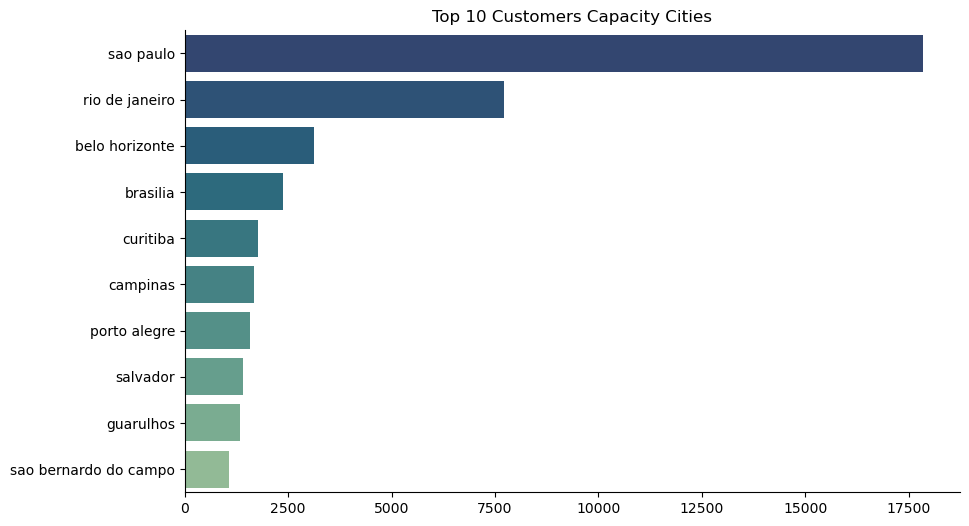

In [22]:
# EDA
# Top 10 Customers Capacity Cities

plt.figure(figsize=[10, 6])
sns.barplot(x = df_cus_seg.customer_city.value_counts().values[:10], 
            y = df_cus_seg.customer_city.value_counts().index[:10], palette= 'crest_r')
plt.title('Top 10 Customers Capacity Cities')
sns.despine()

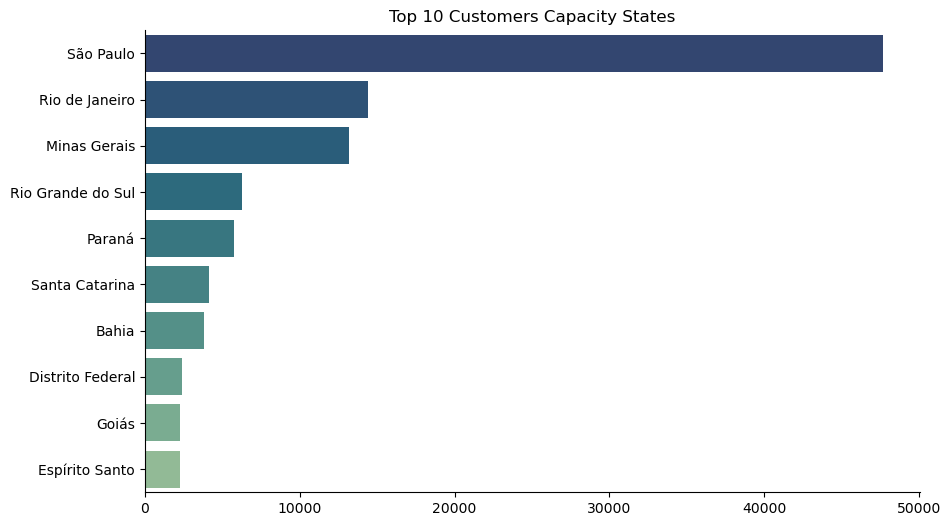

In [23]:
# Top 10 Customers Capacity States

plt.figure(figsize=[10, 6])
sns.barplot(x = df_cus_seg.customer_state.value_counts().values[:10], 
            y = df_cus_seg.customer_state.value_counts().index[:10], palette= 'crest_r')
plt.title('Top 10 Customers Capacity States')
sns.despine()

In [24]:
# Order Status
df_cus_seg.order_status.value_counts()

delivered    112549
canceled          7
Name: order_status, dtype: int64

In [25]:
# Due to the Extreme imbalance and lack of variance in the feature, we should drop it
df_cus_seg.drop('order_status', axis=1, inplace=True)

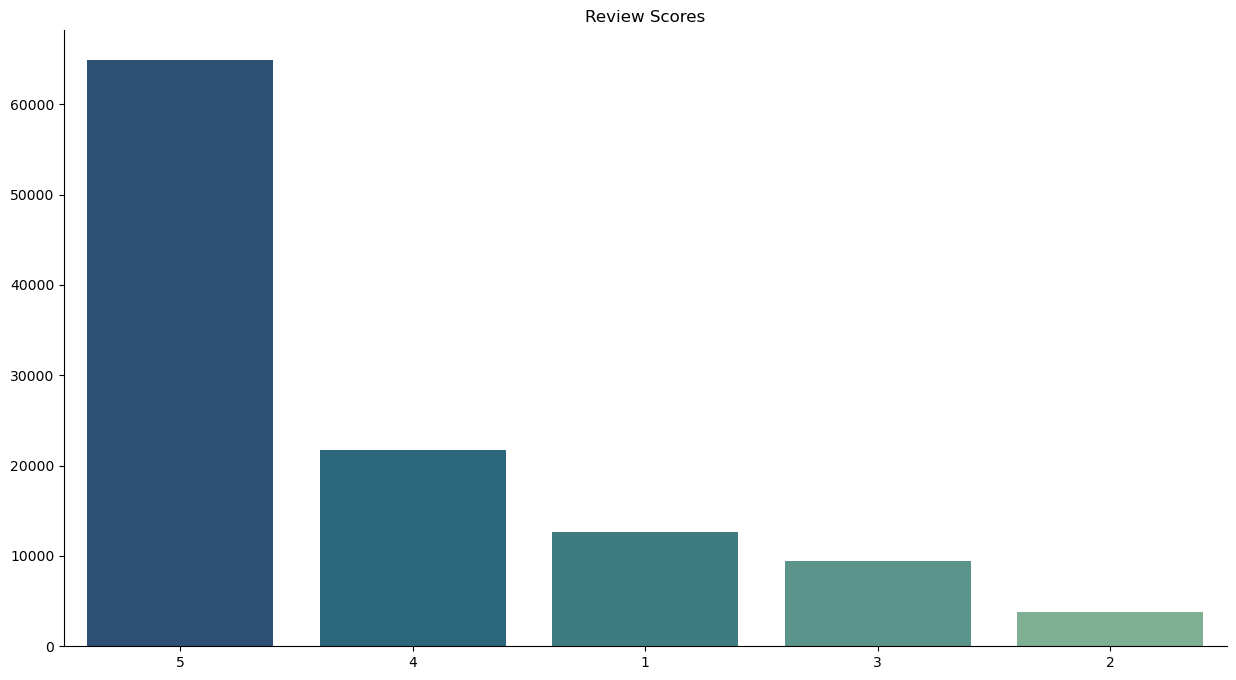

In [26]:
# Review Score
plt.figure(figsize=[15, 8])
review_score_index = [str(i) for i in 
                      df_cus_seg.review_score.value_counts().index]
sns.barplot(x = review_score_index, 
            y= df_cus_seg.review_score.value_counts().values, 
            palette= 'crest_r')
plt.title('Review Scores')
sns.despine()

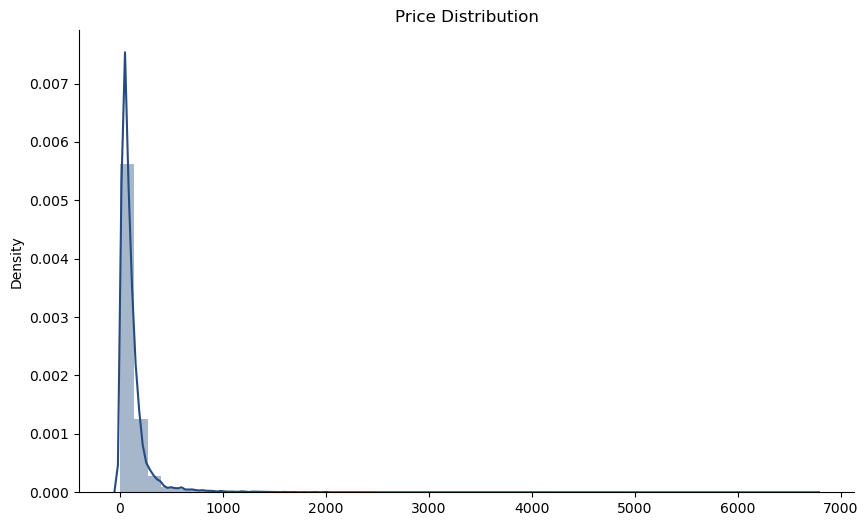

In [27]:
# Price
plt.figure(figsize=[10, 6])
sns.set_palette('crest_r')
sns.distplot(x = df_cus_seg.price)
plt.title('Price Distribution')
sns.despine()

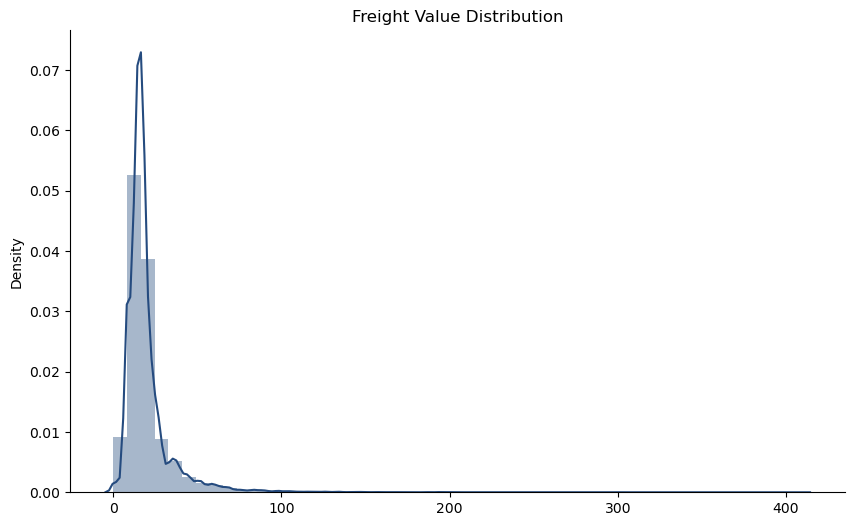

In [28]:
# Freight Value 
plt.figure(figsize=[10, 6])
sns.set_palette('crest_r')
sns.distplot(x = df_cus_seg.freight_value)
plt.title('Freight Value Distribution')
sns.despine()

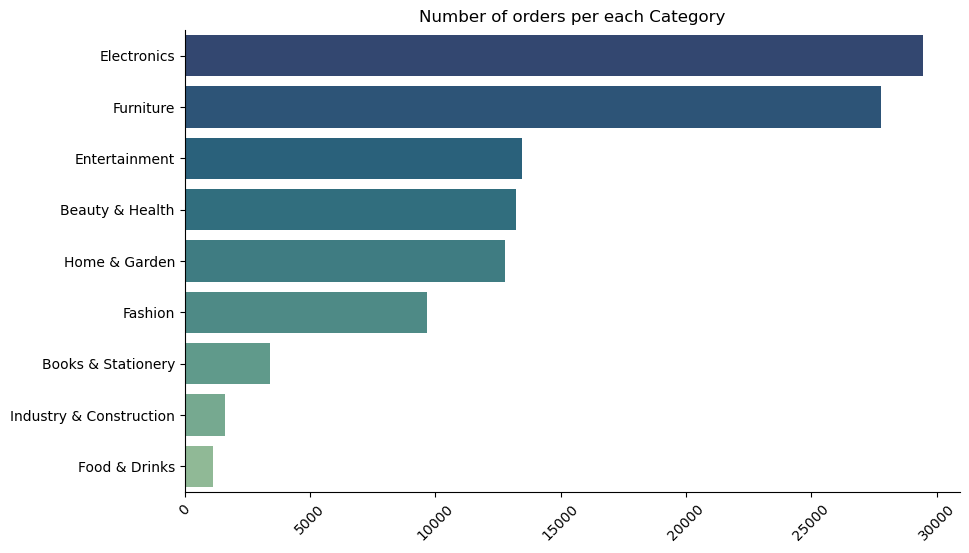

In [29]:
# Number of orders per each Category
plt.figure(figsize=[10, 6])
sns.barplot(x = df_cus_seg.product_category.value_counts().values, 
            y = df_cus_seg.product_category.value_counts().index, palette= 'crest_r')
plt.title('Number of orders per each Category')
plt.xticks(rotation = 45)
sns.despine()

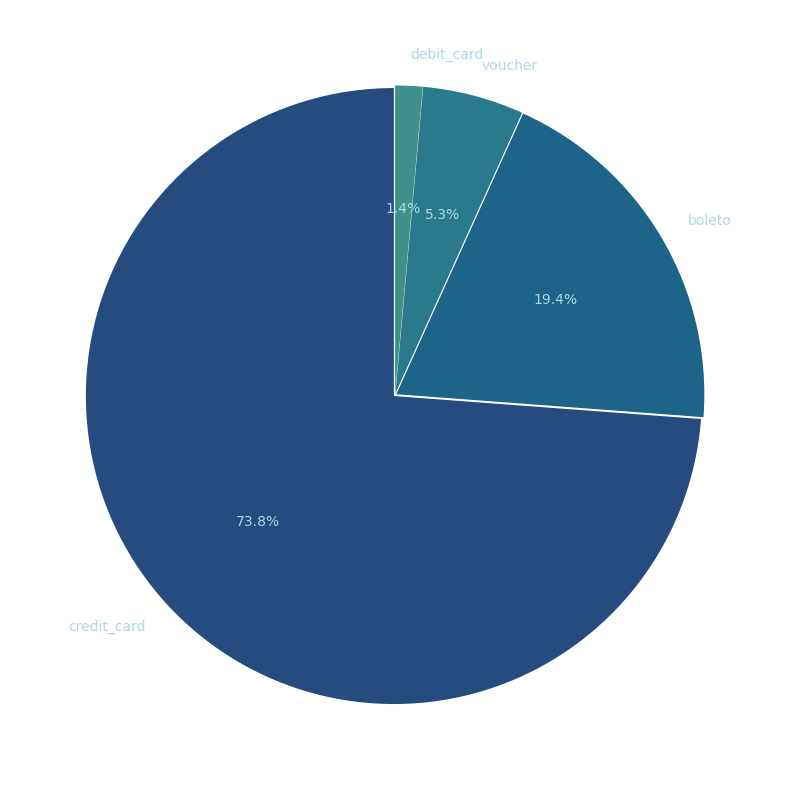

In [30]:
# payment type
plt.figure(figsize=[10, 10])
plt.pie(df_cus_seg.payment_type.value_counts().values, 
        explode=(0.005, 0.005, 0.005, 0.005), 
        labels= df_cus_seg.payment_type.value_counts().index, 
        autopct='%1.1f%%',shadow=False, startangle=90, textprops={'color':"lightblue"});

In [31]:
# Payment Installments
df_cus_seg.payment_installments.value_counts()

1     56134
2     13094
3     11257
4      7635
10     6575
5      5779
8      4845
6      4418
7      1721
9       685
12      157
15       85
18       38
24       34
11       22
20       19
13       18
14       15
17        7
16        7
21        6
0         3
23        1
22        1
Name: payment_installments, dtype: int64

In [32]:
installment0 = df_cus_seg[df_cus_seg.payment_installments == 0]
installment0

customer_id                customer_unique_id  \
55124  48ebb06cf56dba9d009230cc751bb195  9925e1d7dff0d807355599dee04830ab   
55125  48ebb06cf56dba9d009230cc751bb195  9925e1d7dff0d807355599dee04830ab   
89716  5e5794daaa13f73e2f1cdb4114529843  f54cea27c80dc09bfe07b1cf1e01b845   

       customer_zip_code_prefix     customer_city customer_state  \
55124                     44001  feira de santana          Bahia   
55125                     44001  feira de santana          Bahia   
89716                      5263         sao paulo      São Paulo   

                               order_id order_purchase_timestamp  \
55124  1a57108394169c0b47d8f876acc9ba2d      2018-05-15 16:25:14   
55125  1a57108394169c0b47d8f876acc9ba2d      2018-05-15 16:25:14   
89716  744bade1fcf9ff3f31d860ace076d422      2018-04-22 11:34:42   

         order_approved_at order_delivered_carrier_date  \
55124  2018-05-15 16:36:52          2018-05-17 12:37:00   
55125  2018-05-15 16:36:52          2018-05-17 12:37:00   
89716  2018-04-24 19:04:46          2018-04-24 03:14:34   

      order_delivered_customer_date  ...  seller_state product_category  \
55124           2018-05-24 15:45:41  ...  Minas Gerais    Home & Garden   
55125           2018-05-24 15:45:41  ...  Minas Gerais    Home & Garden   
89716           2018-04-27 20:55:28  ...     São Paulo      Electronics   

       estimated_days arrival_days shipping_days  seller_to_carrier_status  \
55124              22            9             7              OnTime/Early   
55125              22            9             7              OnTime/Early   
89716              24            5             3              OnTime/Early   

      arrival_status estimated_delivery_rate arrival_delivery_rate  \
55124   OnTime/Early                 Neutral                  Fast   
55125   OnTime/Early                 Neutral                  Fast   
89716   OnTime/Early                 Neutral             Very Fast   

       shipping_delivery_rate  
55124               Very Fast  
55125               Very Fast  
89716               Very Fast  

[3 rows x 41 columns]

In [33]:
# Number of installments can't be 0, so drop these rows
# Drop rows based on index
df_cus_seg.drop(installment0.index, inplace=True)

# Reset Index
df_cus_seg.reset_index(inplace= True, drop= True) 

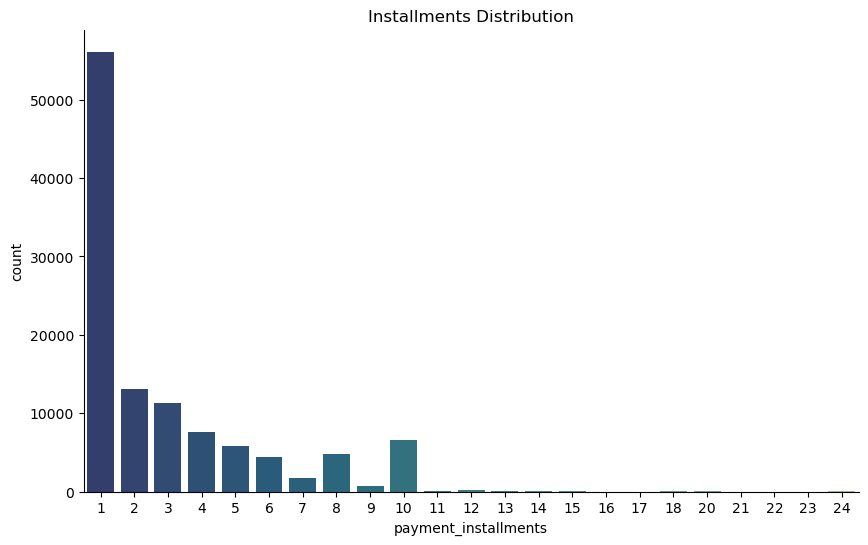

In [34]:
plt.figure(figsize=[10, 6])
sns.countplot(x = df_cus_seg.payment_installments, palette= 'crest_r')
plt.title('Installments Distribution')
sns.despine()

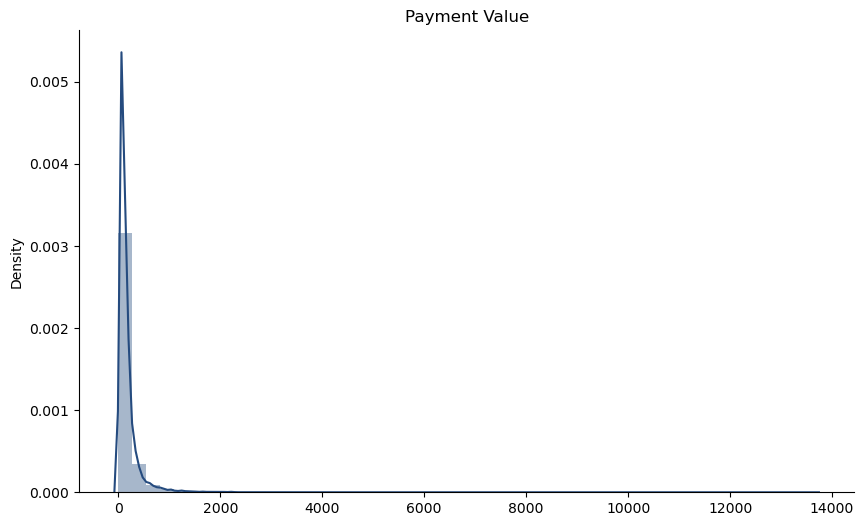

In [35]:
plt.figure(figsize=[10, 6])
sns.distplot(x = df_cus_seg.payment_value)
plt.title('Payment Value')
sns.despine()

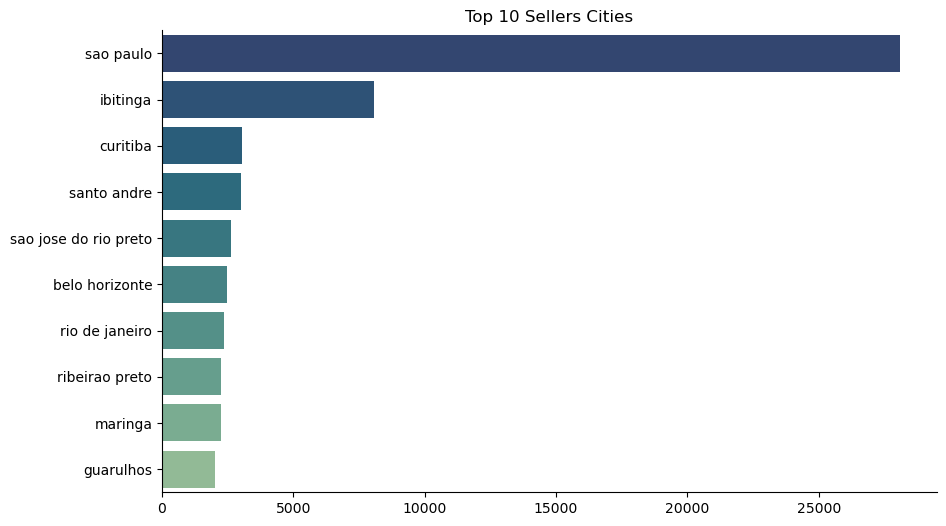

In [36]:
plt.figure(figsize=[10, 6])
sns.barplot(x = df_cus_seg.seller_city.value_counts().values[:10], 
            y= df_cus_seg.seller_city.value_counts().index[:10], palette= 'crest_r')
plt.title('Top 10 Sellers Cities')
sns.despine()

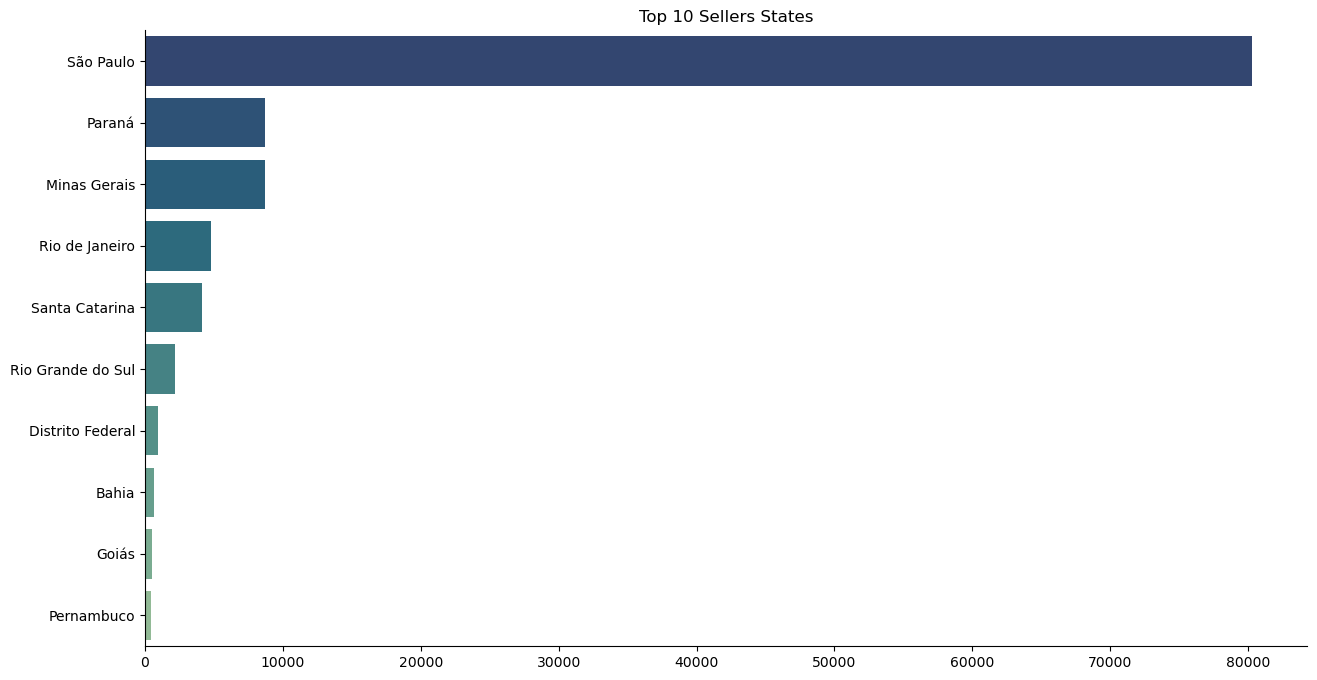

In [37]:
plt.figure(figsize=[15, 8])
sns.barplot(x = df_cus_seg.seller_state.value_counts().values[:10],
            y= df_cus_seg.seller_state.value_counts().index[:10], palette= 'crest_r')
plt.title('Top 10 Sellers States')
sns.despine()

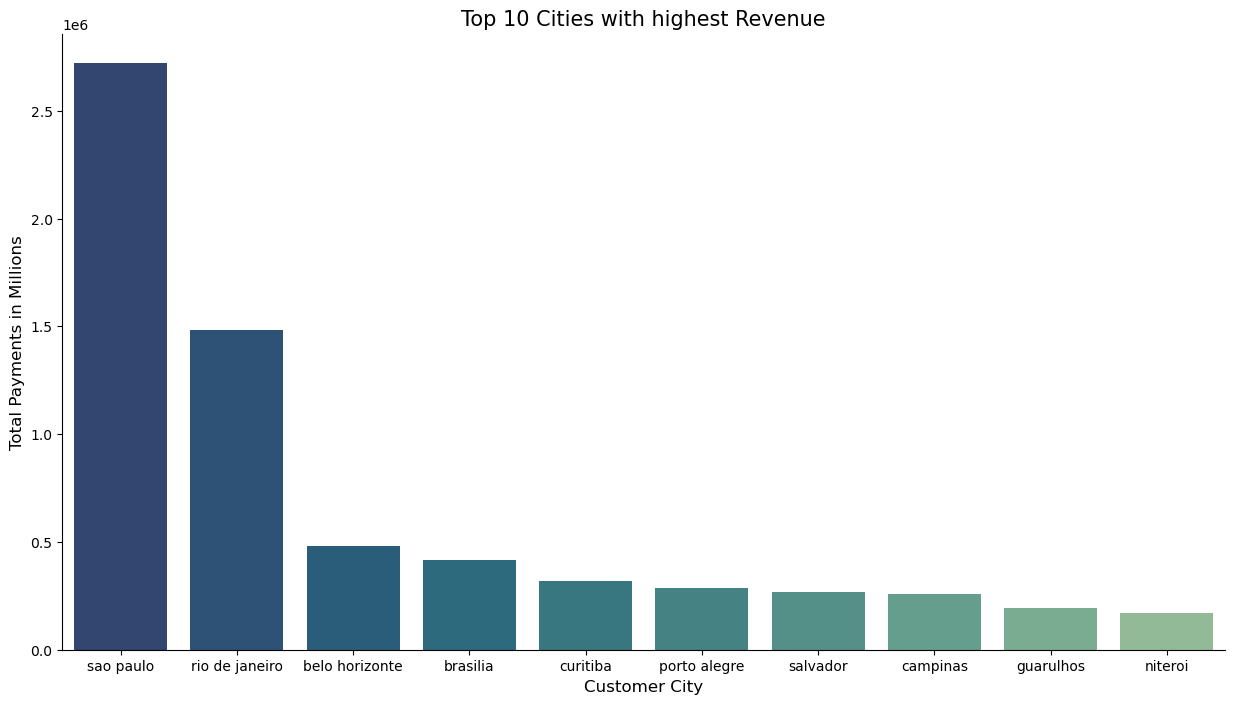

In [38]:
# Which Cities have highest Revenue?
# Group customer city by payment value
revenue_per_city = df_cus_seg.groupby('customer_city')[['payment_value']].sum().sort_values(by='payment_value', ascending=False)
revenue_per_city.reset_index(inplace=True)

# plot Top 10 cities with highest revenue
plt.figure(figsize=[15, 8])
sns.barplot(x = revenue_per_city.customer_city[:10], y= revenue_per_city.payment_value[:10], palette= 'crest_r')
plt.title('Top 10 Cities with highest Revenue', fontsize= 15)
plt.xlabel('Customer City', fontsize= 12)
plt.ylabel('Total Payments in Millions',fontsize= 12)
sns.despine()

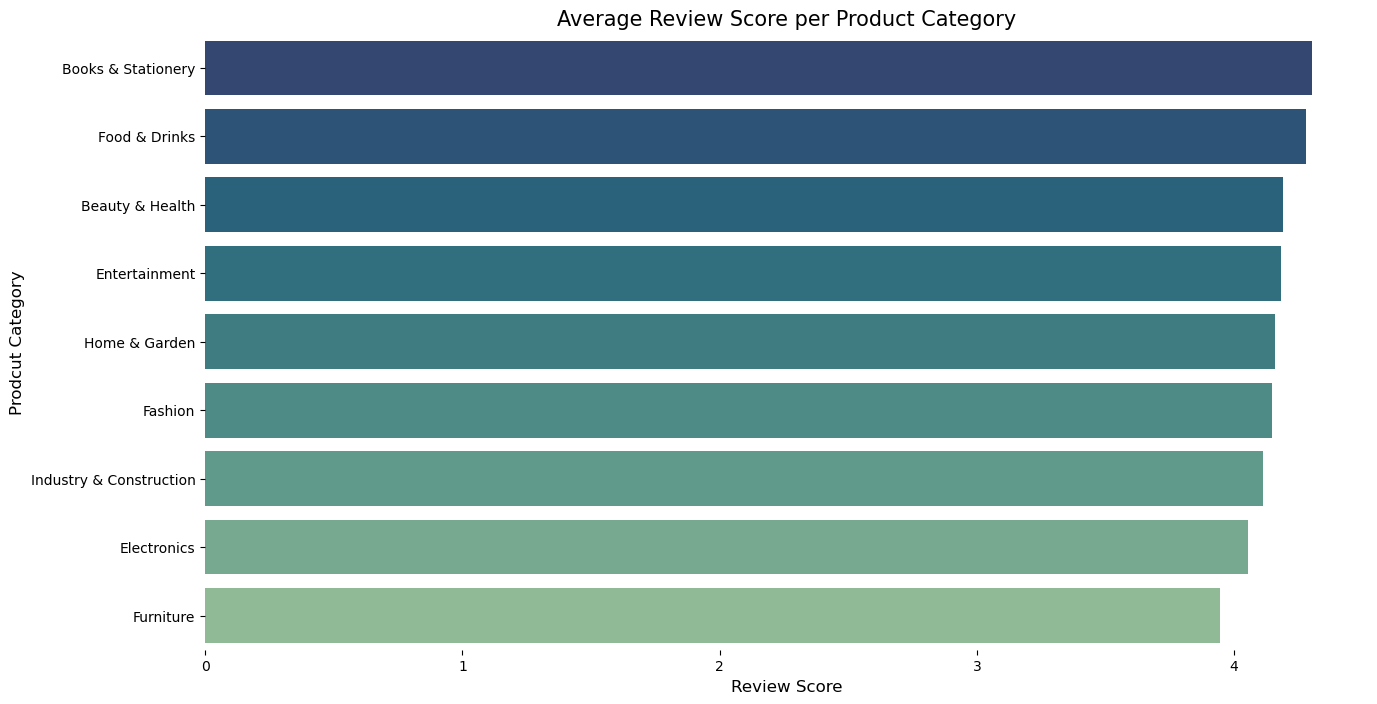

In [39]:
# What is the average review score for each product category ?
# Filter product category with 4.5 or above
review_per_cat = df_cus_seg.groupby('product_category')[['review_score']].mean().sort_values(by='review_score', ascending=False)
review_per_cat.reset_index(inplace=True)

# Plot Product Category vs Review Score
plt.figure(figsize=[15, 8])
sns.barplot(x = review_per_cat.review_score, y= review_per_cat.product_category, palette= 'crest_r')
plt.title('Average Review Score per Product Category', fontsize= 15)
plt.xlabel('Review Score', fontsize=12)
plt.ylabel('Prodcut Category', fontsize= 12)
ax = plt.gca()
ax.set_frame_on(False);

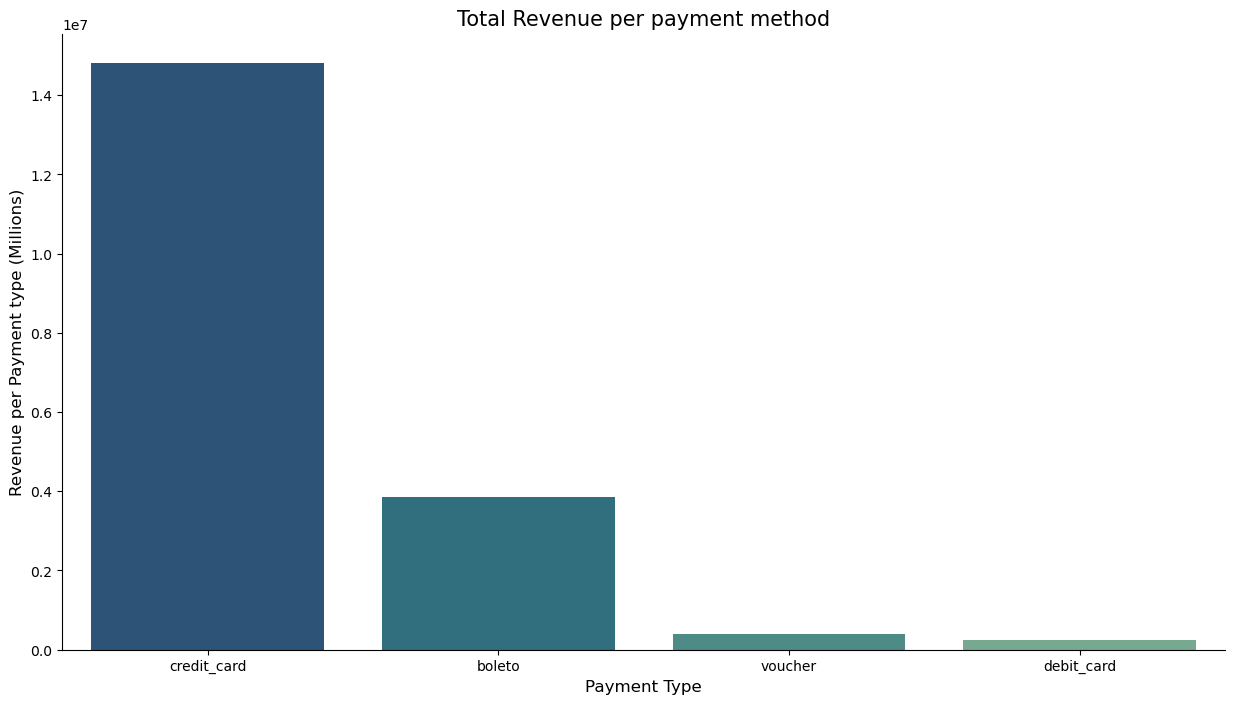

In [40]:
# Are customers more likely to make larger payments using certain payment methods ?
# Group each payment type by average payment value
payment_methods = df_cus_seg.groupby('payment_type')[['payment_value']].sum().sort_values(by='payment_value', ascending=False)
payment_methods.reset_index(inplace=True)

# plot Average payments per payment method
plt.figure(figsize=[15, 8])
sns.barplot(x = payment_methods.payment_type, y= payment_methods.payment_value, palette= 'crest_r')
plt.title('Total Revenue per payment method', fontsize= 15)
plt.xlabel('Payment Type', fontsize= 12)
plt.ylabel('Revenue per Payment type (Millions)', fontsize= 12)
sns.despine()

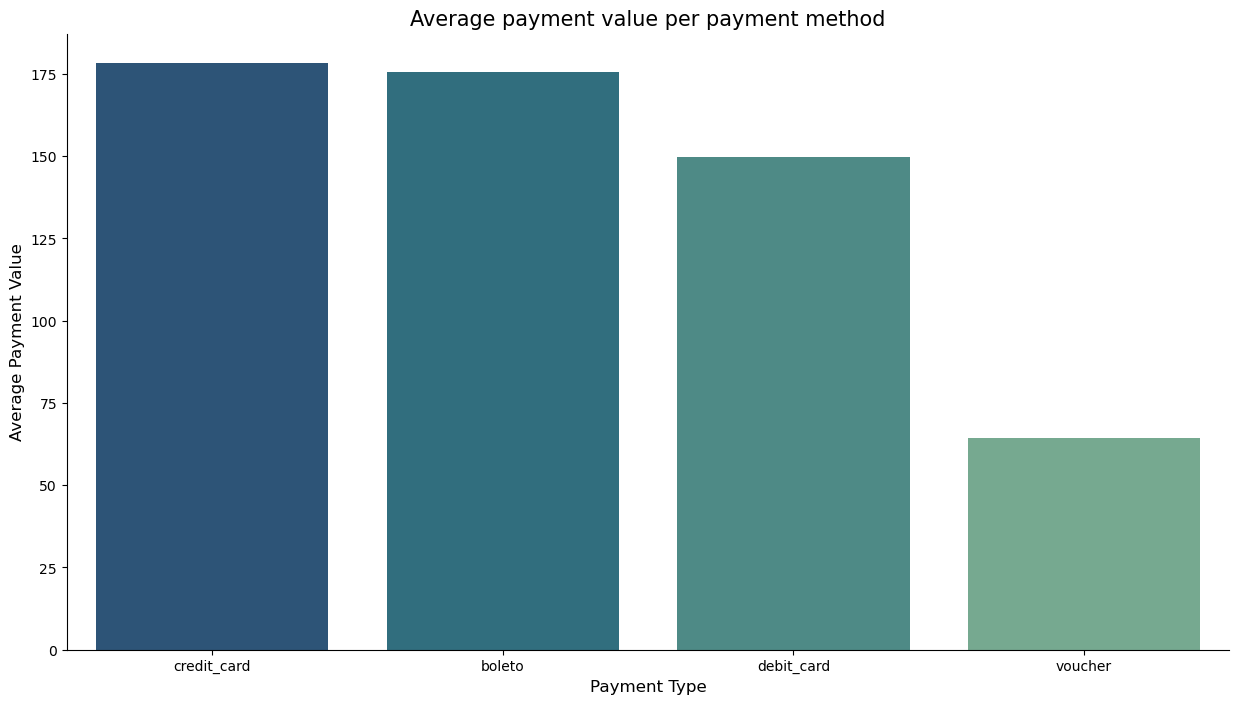

In [41]:
# Group each payment type by average payment value
payment_methods = df_cus_seg.groupby('payment_type')[['payment_value']].mean().sort_values(by='payment_value', ascending=False)
payment_methods.reset_index(inplace=True)

# plot Average payments per payment method
plt.figure(figsize=[15, 8])
sns.barplot(x = payment_methods.payment_type, y= payment_methods.payment_value, palette= 'crest_r')
plt.title('Average payment value per payment method', fontsize= 15)
plt.xlabel('Payment Type', fontsize= 12)
plt.ylabel('Average Payment Value', fontsize= 12)
sns.despine()

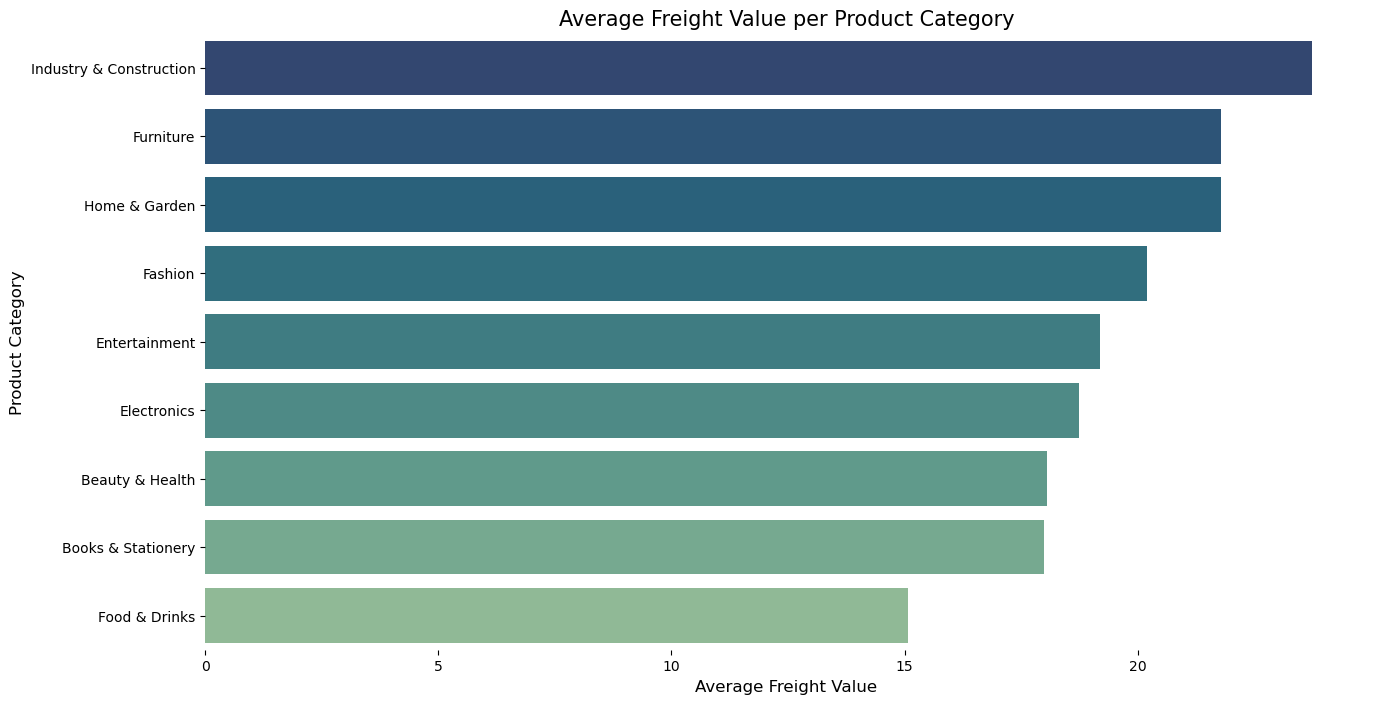

In [42]:
# What is the average freight value for each product category?
# Group product category by average freight value
freight_per_cat = df_cus_seg.groupby('product_category')[['freight_value']].mean().sort_values(by='freight_value', ascending=False)
freight_per_cat.reset_index(inplace=True)

# plot average freight value per product category
plt.figure(figsize=[15, 8])
sns.barplot(x = freight_per_cat.freight_value, y=  freight_per_cat.product_category, palette= 'crest_r')
plt.title('Average Freight Value per Product Category', fontsize= 15)
plt.xlabel('Average Freight Value',fontsize= 12)
plt.ylabel('Product Category', fontsize= 12)
ax = plt.gca()
ax.set_frame_on(False);

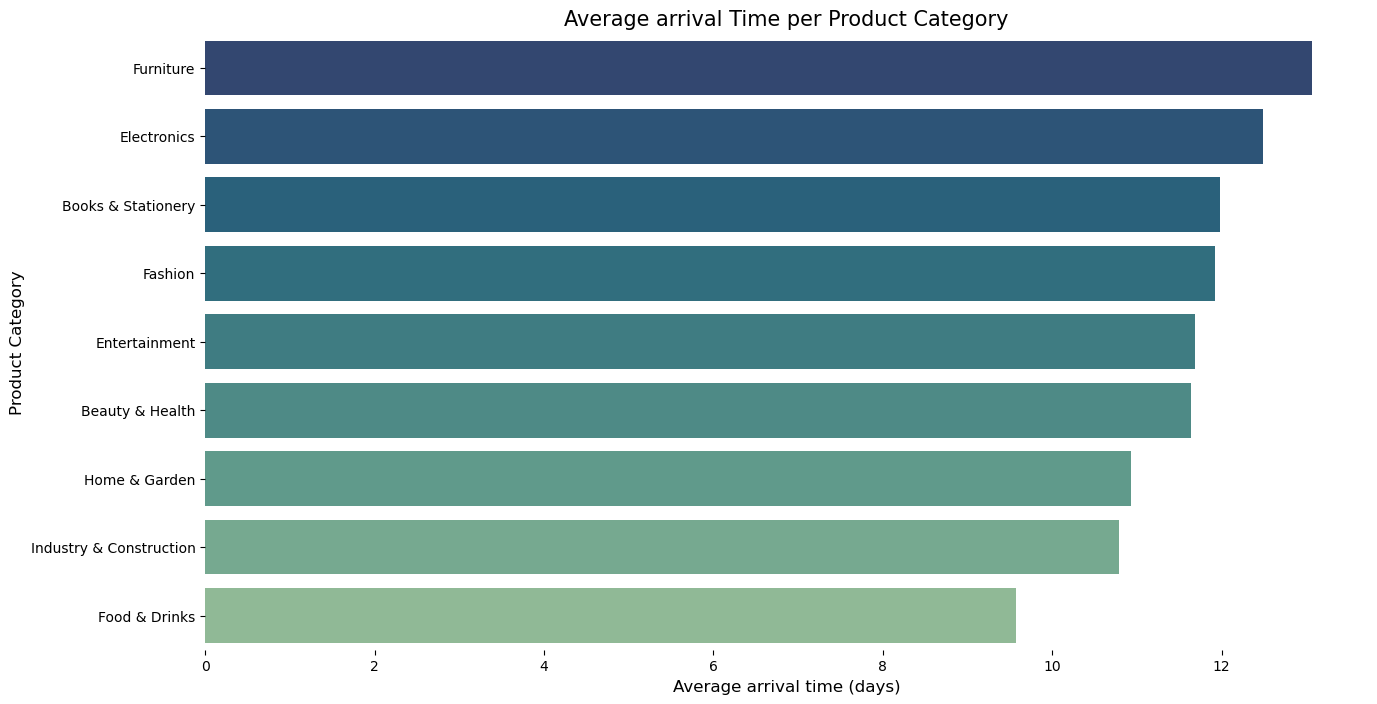

In [43]:
# What is the average shipping time for each product Category?
# Group product category by average arrival time
ship_per_cat = df_cus_seg.groupby('product_category')[['arrival_days']].mean().sort_values(by='arrival_days', ascending=False)
ship_per_cat.reset_index(inplace=True)

# plot average freight value per product category
plt.figure(figsize=[15, 8])
sns.barplot(x = ship_per_cat.arrival_days, y=  ship_per_cat.product_category, palette= 'crest_r')
plt.title('Average arrival Time per Product Category', fontsize= 15)
plt.xlabel('Average arrival time (days)',fontsize= 12)
plt.ylabel('Product Category', fontsize= 12)
ax = plt.gca()
ax.set_frame_on(False);

<AxesSubplot:xlabel='review_score', ylabel='count'>

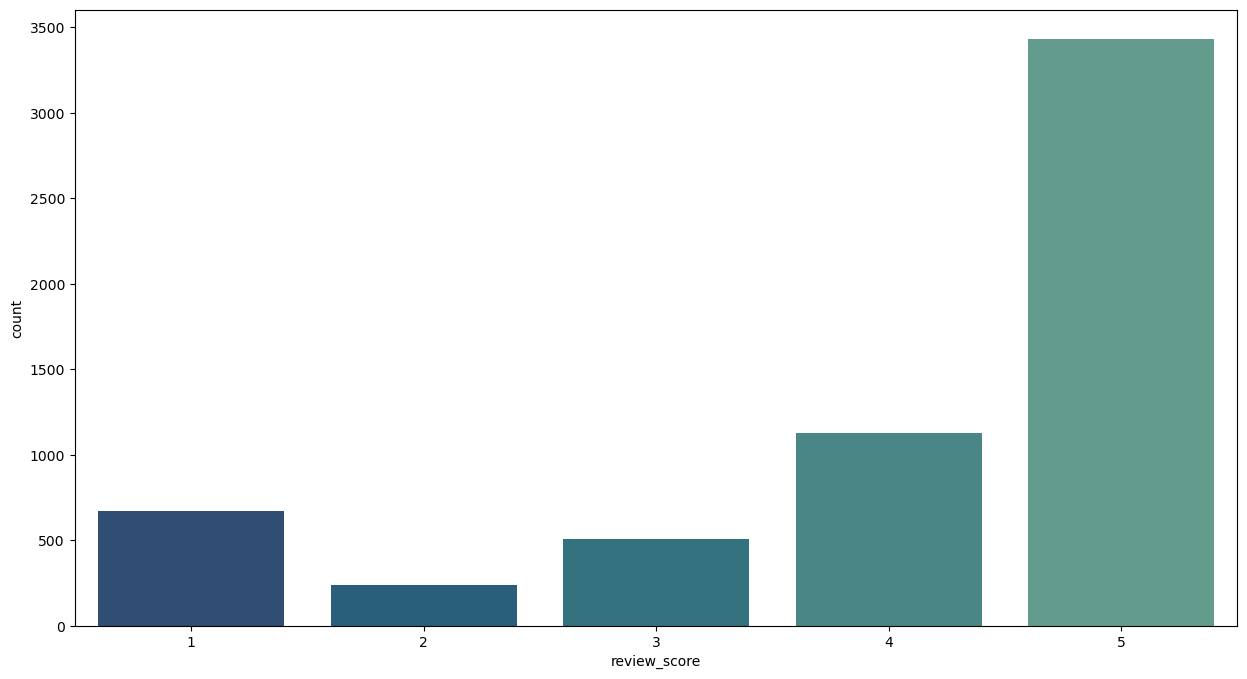

In [44]:
# Are Transactions done with Vouchers lead to high review score?
plt.figure(figsize=[15, 8])
voucher_trans = df_cus_seg[df_cus_seg.payment_type == 'voucher']
sns.countplot(x= voucher_trans.review_score)

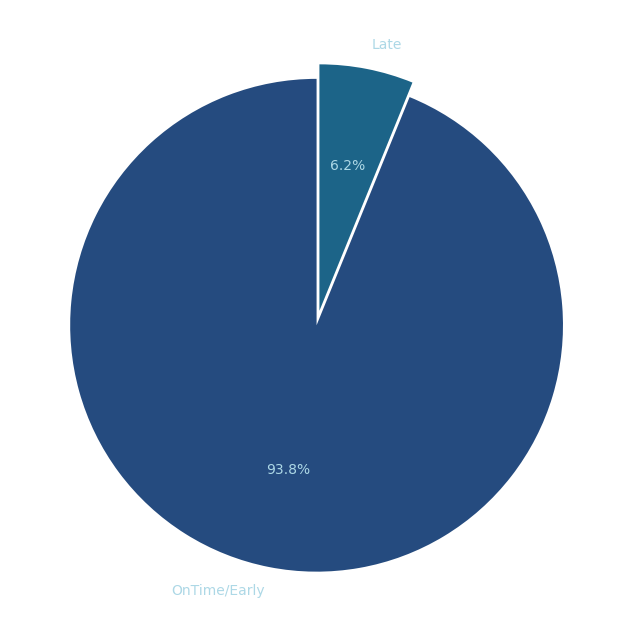

In [45]:
# How accurate are the estimated delivery dates provided to customers?
plt.figure(figsize=[30,8])
Values = df_cus_seg.arrival_status.value_counts().values
Labels = df_cus_seg.arrival_status.value_counts().index
plt.pie(Values, explode=(0.03, 0.03), labels= ['OnTime/Early', 'Late'], 
        autopct='%1.1f%%', shadow=False, startangle=90, 
        textprops={'color':"lightblue"});

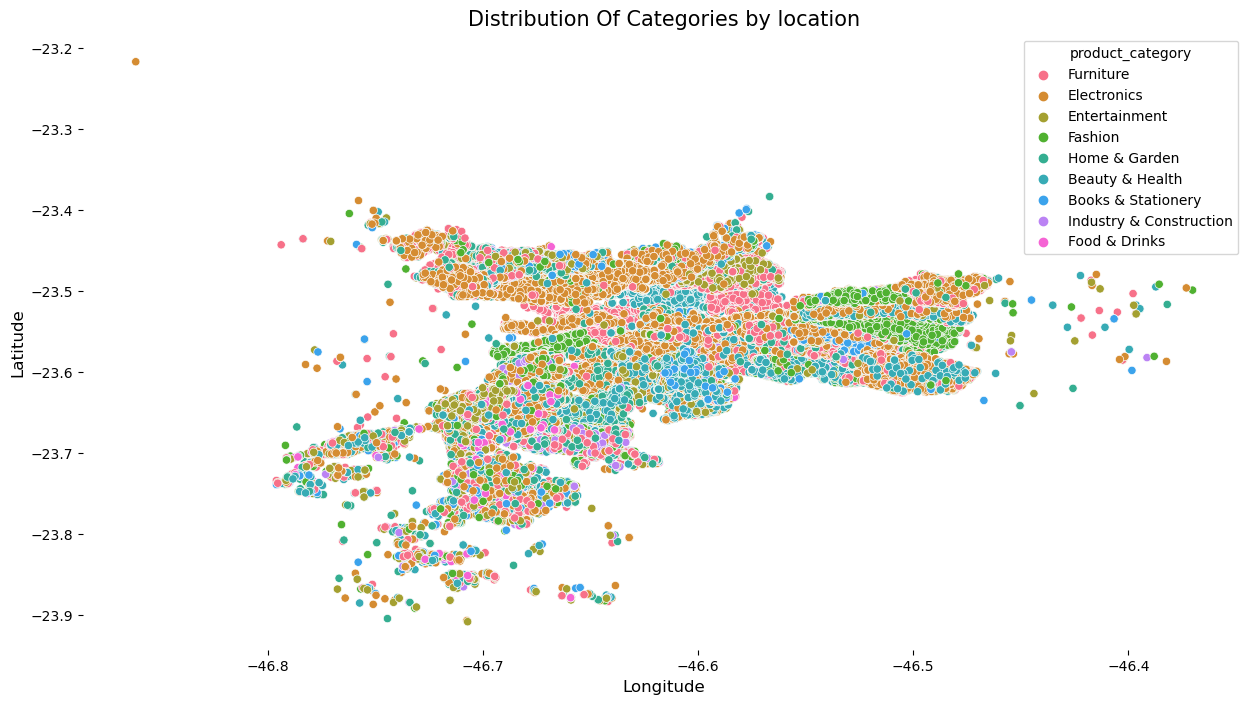

In [46]:

# Distribution of products categories by location
plt.figure(figsize=[15, 8])
sns.scatterplot(x = geolocation.geolocation_lng, 
                y = geolocation.geolocation_lat, 
                hue= df_cus_seg.product_category)
plt.title('Distribution Of Categories by location', fontsize= 15)
plt.xlabel('Longitude',fontsize= 12)
plt.ylabel('Latitude', fontsize= 12)
ax = plt.gca()
ax.set_frame_on(False);sns.despine()

In [47]:
df2 = df_cus_seg.copy()

In [48]:
# Data Preprocessing

In [49]:
# Drop Unneccessary Features
# Drop all ids, zip codes, datetimes, review comment and title, product length

df_cus_seg.drop(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state', 
                 'order_id', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
                 'order_delivered_customer_date', 'order_estimated_delivery_date', 'review_id', 
                 'review_creation_date', 'review_answer_timestamp', 'order_item_id', 
                 'product_id', 'seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state', 
                 'shipping_limit_date', 'product_category', 'product_category_name' ], axis= 1, inplace= True)

<AxesSubplot:>

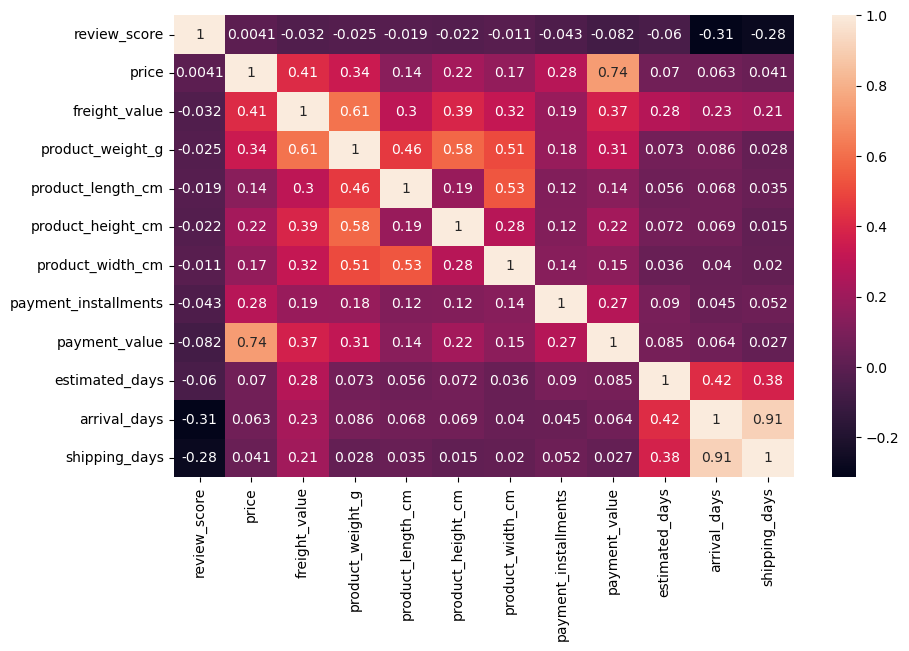

In [50]:
# Show Correlation between Features
plt.figure(figsize= [10, 6])
sns.heatmap(df_cus_seg.corr(), annot= True)

In [51]:
# Remove features with high correlations
df_cus_seg.drop(['shipping_days', 'price'], axis= 1, inplace= True)

In [52]:
df_cus_seg.head()

review_score  freight_value  product_weight_g  product_length_cm  \
0             4          21.88            8683.0               54.0   
1             1          24.90            8683.0               54.0   
2             1          24.90            8683.0               54.0   
3             3          15.62            8683.0               54.0   
4             4          30.59            8683.0               54.0   

   product_height_cm  product_width_cm payment_type  payment_installments  \
0               64.0              31.0  credit_card                     2   
1               64.0              31.0  credit_card                     1   
2               64.0              31.0  credit_card                     1   
3               64.0              31.0  credit_card                     7   
4               64.0              31.0  credit_card                    10   

   payment_value  estimated_days  arrival_days seller_to_carrier_status  \
0         146.87              20             9                     Late   
1         275.79              40            19             OnTime/Early   
2         275.79              40            19             OnTime/Early   
3         140.61              36            19             OnTime/Early   
4         137.58              47            25                     Late   

  arrival_status estimated_delivery_rate arrival_delivery_rate  \
0   OnTime/Early                 Neutral                  Fast   
1   OnTime/Early               Very Slow               Neutral   
2   OnTime/Early               Very Slow               Neutral   
3   OnTime/Early                    Slow               Neutral   
4   OnTime/Early               Very Slow                  Slow   

  shipping_delivery_rate  
0              Very Fast  
1              Very Fast  
2              Very Fast  
3              Very Fast  
4                   Fast

In [53]:
# Convert Review Score from Multiclass to Binary
encoded_class = { 1 : 'Not Satisfied',
                  2 : 'Not Satisfied', 
                  3 : 'Not Satisfied', 
                  4 : 'Satisfied', 
                  5 : 'Satisfied'}

df_cus_seg['review_score'] = df_cus_seg['review_score'].map(encoded_class)

In [54]:
# Split Data into Input Features & Target Variable
X = df_cus_seg.drop('review_score', axis=1)
y = df_cus_seg['review_score']

In [55]:
# Handling Categorical Features
# Handling Ordinal Features ( Label Encoding)
labels = {'Very Slow' : 1, 
          'Slow' : 2, 
          'Neutral' : 3, 
          'Fast' : 4, 
          'Very Fast' : 5}

X.estimated_delivery_rate = X.estimated_delivery_rate.map(labels)
X.shipping_delivery_rate = X.shipping_delivery_rate.map(labels)
X.arrival_delivery_rate = X.arrival_delivery_rate.map(labels)

In [56]:
# Handling Nominal Features ( One Hot Encoding )
X = pd.get_dummies(X, drop_first=True)

In [57]:
# Split Data into Train & Test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 42, stratify= y)

In [58]:
# Feature Selection

from sklearn.feature_selection import mutual_info_classif, SelectKBest
fs = SelectKBest(mutual_info_classif, k= 'all')
fs.fit(x_train, y_train)
x_train_fs = fs.transform(x_train)
x_test_fs = fs.transform(x_test)

<AxesSubplot:>

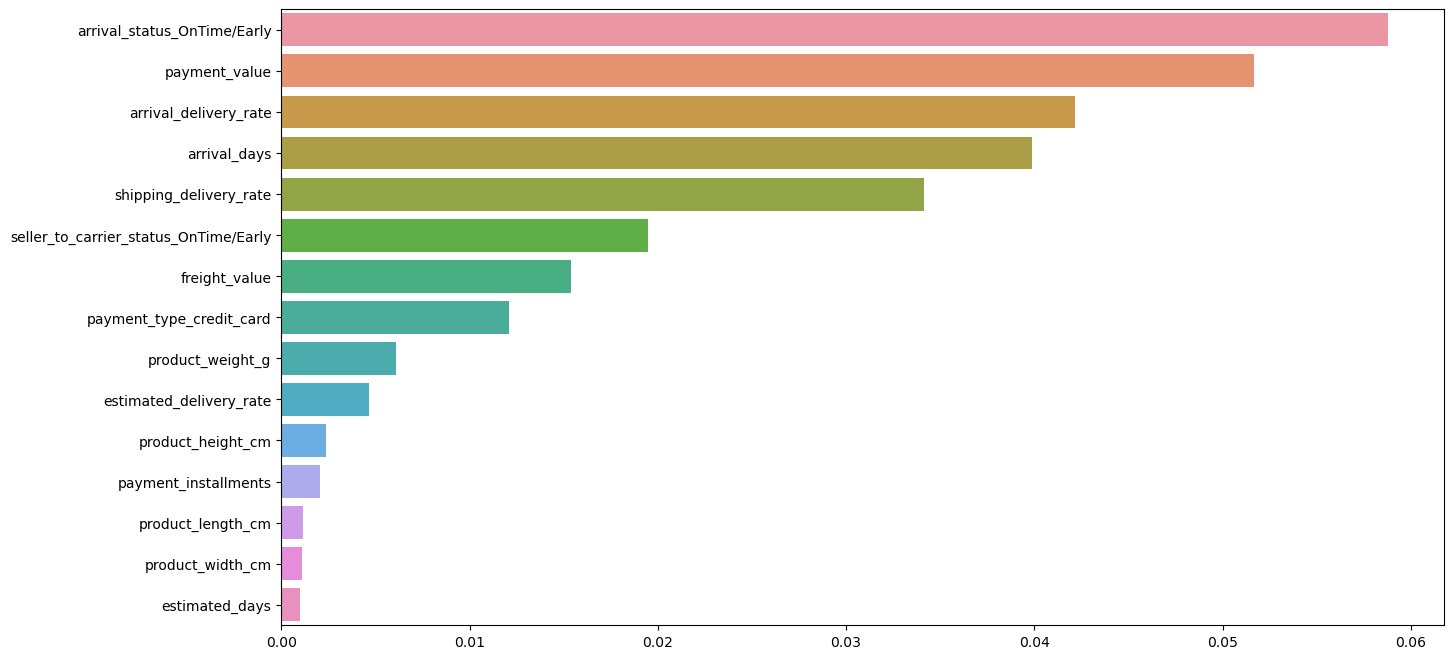

In [59]:
# Plotting Featres as per importance

# Get the indices sorted by most important to least important
plt.figure(figsize=[15, 8])
indices = np.argsort(fs.scores_)[::-1]

# To get your top 10 feature names
features = []
for i in range(15):
    features.append(fs.feature_names_in_[indices[i]])

# Now plot
sns.barplot(x = fs.scores_[indices[range(15)]], y = features)

In [60]:
# Select best 9 Features
from sklearn.feature_selection import mutual_info_classif, SelectKBest
fs = SelectKBest(mutual_info_classif, k= 9)
fs.fit(x_train, y_train)
x_train_fs = fs.transform(x_train)
x_test_fs = fs.transform(x_test)

In [61]:
x_train_fs = pd.DataFrame(x_train_fs, columns= fs.get_feature_names_out())
x_test_fs = pd.DataFrame(x_test_fs, columns= fs.get_feature_names_out())

In [62]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean= False)
x_train_scaled = sc.fit_transform(x_train_fs)
x_test_scaled = sc.transform(x_test_fs)

In [63]:
# Convert Array to Dataframe
x_train_scaled = pd.DataFrame(x_train_scaled, columns= sc.get_feature_names_out())
x_test_scaled = pd.DataFrame(x_test_scaled, columns= sc.get_feature_names_out())

In [64]:
# Handling Imbalance

In [65]:
# Check imbalance percentage
round((y_train.value_counts() / y_train.shape[0]) * 100, 2)

Satisfied        76.99
Not Satisfied    23.01
Name: review_score, dtype: float64

In [66]:
# Use SMOTE for handling imbalance
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state= 42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_scaled, y_train)

In [67]:
# Modeling
# Apply ML Models

Evaluation on Training 
                precision    recall  f1-score   support

Not Satisfied       0.70      0.42      0.53     69319
    Satisfied       0.59      0.82      0.68     69319

     accuracy                           0.62    138638
    macro avg       0.64      0.62      0.60    138638
 weighted avg       0.64      0.62      0.60    138638

Evaluation on Testing 
                precision    recall  f1-score   support

Not Satisfied       0.39      0.41      0.40      5181
    Satisfied       0.82      0.81      0.82     17330

     accuracy                           0.72     22511
    macro avg       0.61      0.61      0.61     22511
 weighted avg       0.72      0.72      0.72     22511



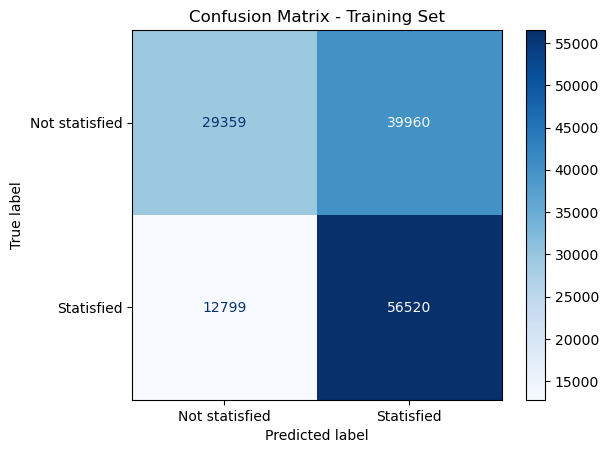

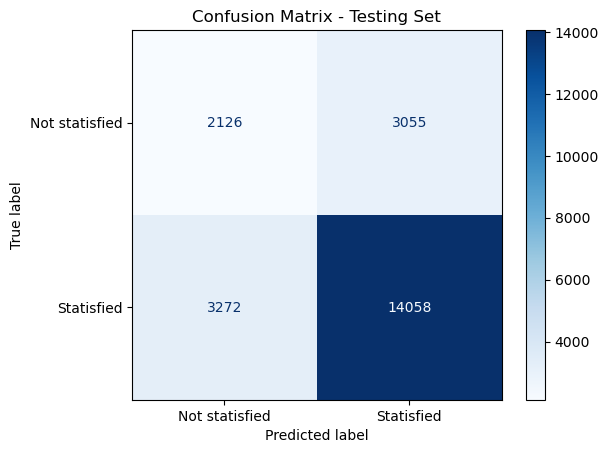

In [68]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

lr = LogisticRegression()
lr.fit(x_train_resampled, y_train_resampled)

print('Evaluation on Training \n', classification_report(y_train_resampled, lr.predict(x_train_resampled)))
print('Evaluation on Testing \n', classification_report(y_test, lr.predict(x_test_scaled)))

# Get confusion matrix for training set
cm_train = confusion_matrix(y_train_resampled, lr.predict(x_train_resampled))

# Get confusion matrix for testing set
cm_test = confusion_matrix(y_test, lr.predict(x_test_scaled))

# Plot confusion matrix for training set
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['Not statisfied', 'Statisfied'])
disp_train.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Training Set')
plt.show()

# Plot confusion matrix for testing set
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Not statisfied', 'Statisfied'])
disp_test.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Testing Set')
plt.show()

Evaluation on Training 
                precision    recall  f1-score   support

Not Satisfied       0.82      0.93      0.87     69319
    Satisfied       0.92      0.80      0.86     69319

     accuracy                           0.87    138638
    macro avg       0.87      0.87      0.86    138638
 weighted avg       0.87      0.87      0.86    138638

Evaluation on Testing 
                precision    recall  f1-score   support

Not Satisfied       0.37      0.58      0.45      5181
    Satisfied       0.85      0.70      0.77     17330

     accuracy                           0.67     22511
    macro avg       0.61      0.64      0.61     22511
 weighted avg       0.74      0.67      0.69     22511



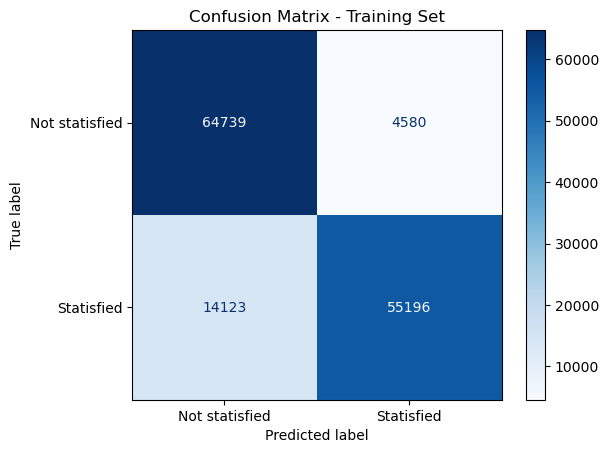

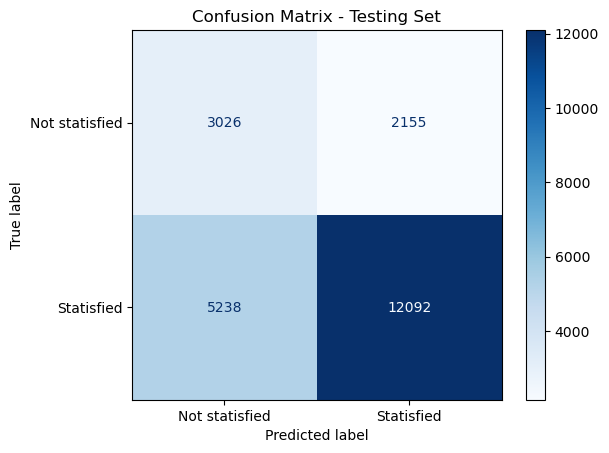

In [69]:
# KNN Classifier
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(x_train_resampled, y_train_resampled)

print('Evaluation on Training \n', classification_report(y_train_resampled, knn.predict(x_train_resampled)))
print('Evaluation on Testing \n', classification_report(y_test, knn.predict(x_test_scaled)))

# Get confusion matrix for training set
cm_train = confusion_matrix(y_train_resampled, knn.predict(x_train_resampled))

# Get confusion matrix for testing set
cm_test = confusion_matrix(y_test, knn.predict(x_test_scaled))

# Plot confusion matrix for training set
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['Not statisfied', 'Statisfied'])
disp_train.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Training Set')
plt.show()

# Plot confusion matrix for testing set
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Not statisfied', 'Statisfied'])
disp_test.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Testing Set')
plt.show()

Evaluation on Training 
                precision    recall  f1-score   support

Not Satisfied       0.99      1.00      0.99     69319
    Satisfied       1.00      0.99      0.99     69319

     accuracy                           0.99    138638
    macro avg       0.99      0.99      0.99    138638
 weighted avg       0.99      0.99      0.99    138638

Evaluation on Testing 
                precision    recall  f1-score   support

Not Satisfied       0.43      0.54      0.48      5181
    Satisfied       0.85      0.79      0.82     17330

     accuracy                           0.73     22511
    macro avg       0.64      0.66      0.65     22511
 weighted avg       0.75      0.73      0.74     22511



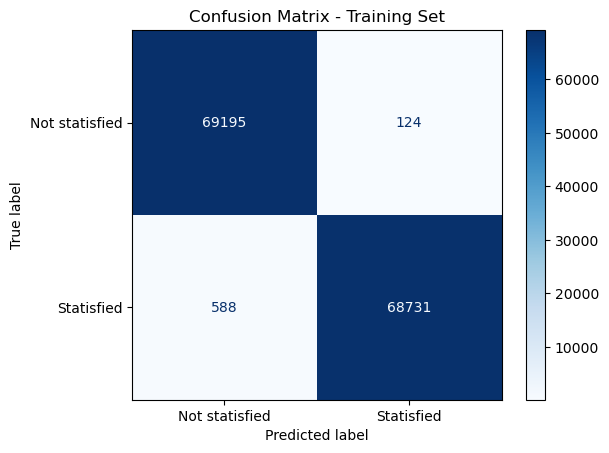

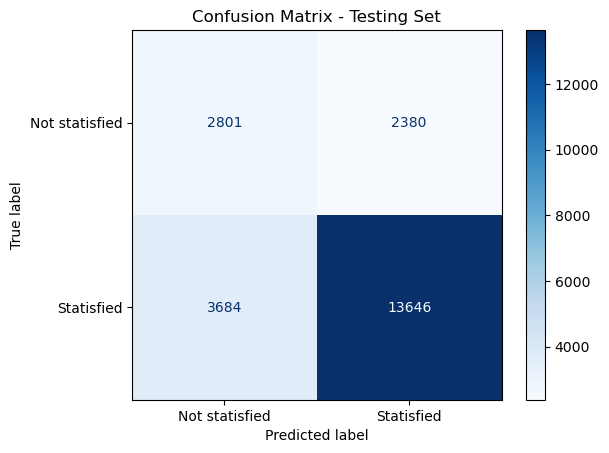

In [70]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(x_train_resampled, y_train_resampled)

print('Evaluation on Training \n', classification_report(y_train_resampled, dt.predict(x_train_resampled)))
print('Evaluation on Testing \n', classification_report(y_test, dt.predict(x_test_scaled)))

# Get confusion matrix for training set
cm_train = confusion_matrix(y_train_resampled, dt.predict(x_train_resampled))

# Get confusion matrix for testing set
cm_test = confusion_matrix(y_test, dt.predict(x_test_scaled))

# Plot confusion matrix for training set
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['Not statisfied', 'Statisfied'])
disp_train.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Training Set')
plt.show()

# Plot confusion matrix for testing set
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Not statisfied', 'Statisfied'])
disp_test.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Testing Set')
plt.show()

Evaluation on Training 
                precision    recall  f1-score   support

Not Satisfied       1.00      0.99      0.99     69319
    Satisfied       0.99      1.00      0.99     69319

     accuracy                           0.99    138638
    macro avg       0.99      0.99      0.99    138638
 weighted avg       0.99      0.99      0.99    138638

Evaluation on Testing 
                precision    recall  f1-score   support

Not Satisfied       0.56      0.49      0.53      5181
    Satisfied       0.85      0.88      0.87     17330

     accuracy                           0.79     22511
    macro avg       0.71      0.69      0.70     22511
 weighted avg       0.79      0.79      0.79     22511



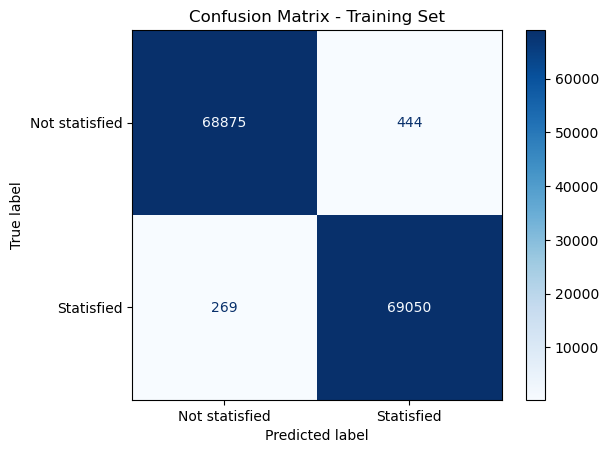

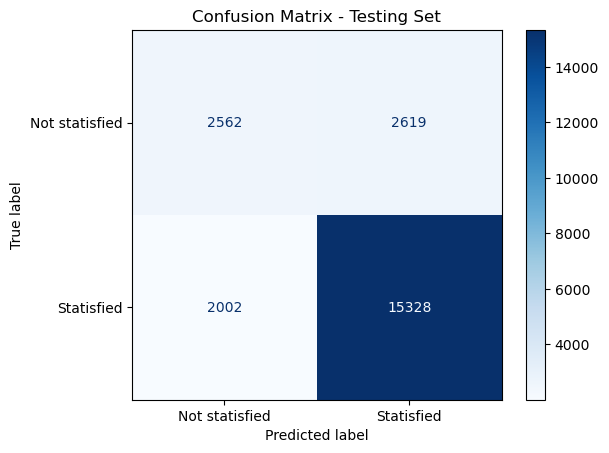

In [71]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(x_train_resampled, y_train_resampled)

print('Evaluation on Training \n', classification_report(y_train_resampled, rf.predict(x_train_resampled)))
print('Evaluation on Testing \n', classification_report(y_test, rf.predict(x_test_scaled)))

# Get confusion matrix for training set
cm_train = confusion_matrix(y_train_resampled, rf.predict(x_train_resampled))

# Get confusion matrix for testing set
cm_test = confusion_matrix(y_test, rf.predict(x_test_scaled))

# Plot confusion matrix for training set
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['Not statisfied', 'Statisfied'])
disp_train.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Training Set')
plt.show()

# Plot confusion matrix for testing set
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Not statisfied', 'Statisfied'])
disp_test.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Testing Set')
plt.show()

Evaluation on Training 
               precision    recall  f1-score   support

           0       0.83      0.67      0.74     69319
           1       0.73      0.87      0.79     69319

    accuracy                           0.77    138638
   macro avg       0.78      0.77      0.77    138638
weighted avg       0.78      0.77      0.77    138638

Evaluation on Testing 
               precision    recall  f1-score   support

           0       0.44      0.40      0.42      5181
           1       0.83      0.85      0.84     17330

    accuracy                           0.74     22511
   macro avg       0.63      0.62      0.63     22511
weighted avg       0.74      0.74      0.74     22511



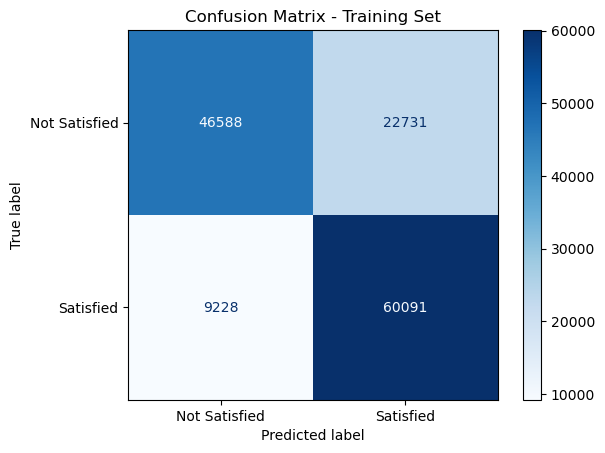

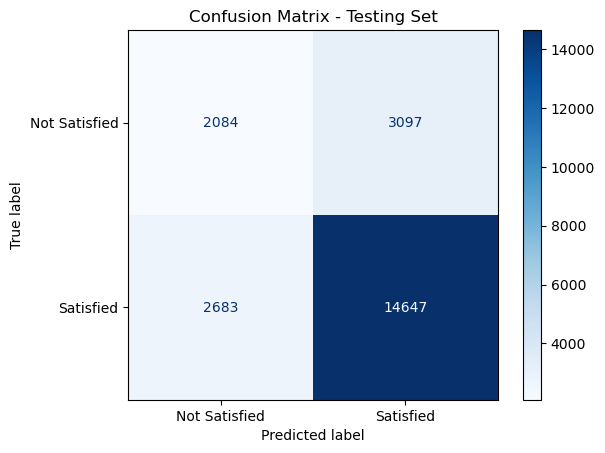

In [72]:
#  XGboost
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Label encode the target variables
le = LabelEncoder()
y_train_xg = le.fit_transform(y_train_resampled)
y_test_xg = le.fit_transform(y_test)

# Train XGBoost model
xg = XGBClassifier()
xg.fit(x_train_resampled, y_train_xg)

# Evaluate on training set
print('Evaluation on Training \n', classification_report(y_train_xg, xg.predict(x_train_resampled)))

# Evaluate on testing set
print('Evaluation on Testing \n', classification_report(y_test_xg, xg.predict(x_test_scaled)))

# Get confusion matrix for training set
cm_train = confusion_matrix(y_train_xg, xg.predict(x_train_resampled))

# Get confusion matrix for testing set
cm_test = confusion_matrix(y_test_xg, xg.predict(x_test_scaled))

# Plot confusion matrix for training set
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['Not Satisfied', 'Satisfied'])
disp_train.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Training Set')
plt.show()

# Plot confusion matrix for testing set
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Not Satisfied', 'Satisfied'])
disp_test.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Testing Set')
plt.show()

In [73]:
# Hyperparameter Tuning

# XGboost
# Create an instance of XGBClassifier with specified hyperparameters
final_xg_model = XGBClassifier(learning_rate=0.2, max_depth=8, n_estimators=200)

# Train the XGBoost model on the resampled training data
final_xg_model.fit(x_train_resampled, y_train_xg)

# Evaluate the performance of the trained model on the training set
print('Evaluation on Training \n', classification_report(y_train_xg, final_xg_model.predict(x_train_resampled)))

# Evaluate the performance of the trained model on the testing set
print('Evaluation on Testing \n', classification_report(y_test_xg, final_xg_model.predict(x_test_scaled)))


Evaluation on Training 
               precision    recall  f1-score   support

           0       0.90      0.77      0.83     69319
           1       0.80      0.92      0.86     69319

    accuracy                           0.85    138638
   macro avg       0.85      0.85      0.84    138638
weighted avg       0.85      0.85      0.84    138638

Evaluation on Testing 
               precision    recall  f1-score   support

           0       0.48      0.44      0.46      5181
           1       0.84      0.86      0.85     17330

    accuracy                           0.76     22511
   macro avg       0.66      0.65      0.65     22511
weighted avg       0.76      0.76      0.76     22511



In [74]:
import catboost as cb
final_cb_model = cb.CatBoostClassifier(depth= 7, iterations= 200, learning_rate= 0.2)
final_cb_model.fit(x_train_resampled,y_train_resampled)
print('Evaluation on Training \n', classification_report(y_train_resampled, final_cb_model.predict(x_train_resampled)))
print('Evaluation on Testing \n', classification_report(y_test, final_cb_model.predict(x_test_scaled)))

0:	learn: 0.6669931	total: 173ms	remaining: 34.5s
1:	learn: 0.6501213	total: 199ms	remaining: 19.7s
2:	learn: 0.6374465	total: 224ms	remaining: 14.7s
3:	learn: 0.6274571	total: 253ms	remaining: 12.4s
4:	learn: 0.6230634	total: 277ms	remaining: 10.8s
5:	learn: 0.6195114	total: 307ms	remaining: 9.91s
6:	learn: 0.6165961	total: 335ms	remaining: 9.23s
7:	learn: 0.6144969	total: 363ms	remaining: 8.72s
8:	learn: 0.6115192	total: 393ms	remaining: 8.34s
9:	learn: 0.6089206	total: 428ms	remaining: 8.13s
10:	learn: 0.6032721	total: 454ms	remaining: 7.81s
11:	learn: 0.6020250	total: 484ms	remaining: 7.58s
12:	learn: 0.6006725	total: 513ms	remaining: 7.38s
13:	learn: 0.5975907	total: 544ms	remaining: 7.23s
14:	learn: 0.5957044	total: 577ms	remaining: 7.12s
15:	learn: 0.5946921	total: 609ms	remaining: 7s
16:	learn: 0.5916419	total: 649ms	remaining: 6.98s
17:	learn: 0.5890738	total: 681ms	remaining: 6.89s
18:	learn: 0.5880070	total: 712ms	remaining: 6.78s
19:	learn: 0.5848508	total: 747ms	remaining:

162:	learn: 0.4754428	total: 5.91s	remaining: 1.34s
163:	learn: 0.4752146	total: 5.95s	remaining: 1.31s
164:	learn: 0.4748441	total: 5.99s	remaining: 1.27s
165:	learn: 0.4745495	total: 6.03s	remaining: 1.24s
166:	learn: 0.4743532	total: 6.07s	remaining: 1.2s
167:	learn: 0.4739991	total: 6.11s	remaining: 1.16s
168:	learn: 0.4737537	total: 6.15s	remaining: 1.13s
169:	learn: 0.4731066	total: 6.2s	remaining: 1.09s
170:	learn: 0.4727559	total: 6.24s	remaining: 1.06s
171:	learn: 0.4725848	total: 6.28s	remaining: 1.02s
172:	learn: 0.4724164	total: 6.33s	remaining: 988ms
173:	learn: 0.4720543	total: 6.38s	remaining: 954ms
174:	learn: 0.4719131	total: 6.43s	remaining: 919ms
175:	learn: 0.4717278	total: 6.47s	remaining: 883ms
176:	learn: 0.4710119	total: 6.51s	remaining: 846ms
177:	learn: 0.4707417	total: 6.56s	remaining: 810ms
178:	learn: 0.4705638	total: 6.6s	remaining: 774ms
179:	learn: 0.4702845	total: 6.65s	remaining: 739ms
180:	learn: 0.4700075	total: 6.7s	remaining: 703ms
181:	learn: 0.46

In [75]:
# RandomForest
final_rf_model = RandomForestClassifier(n_estimators= 200, max_depth= 10)
final_rf_model.fit(x_train_resampled,y_train_resampled)
print('Evaluation on Training \n', classification_report(y_train_resampled, final_rf_model.predict(x_train_resampled)))
print('Evaluation on Testing \n', classification_report(y_test, final_rf_model.predict(x_test_scaled)))

Evaluation on Training 
                precision    recall  f1-score   support

Not Satisfied       0.77      0.52      0.62     69319
    Satisfied       0.64      0.85      0.73     69319

     accuracy                           0.68    138638
    macro avg       0.71      0.68      0.68    138638
 weighted avg       0.71      0.68      0.68    138638

Evaluation on Testing 
                precision    recall  f1-score   support

Not Satisfied       0.44      0.42      0.43      5181
    Satisfied       0.83      0.84      0.83     17330

     accuracy                           0.74     22511
    macro avg       0.63      0.63      0.63     22511
 weighted avg       0.74      0.74      0.74     22511



In [76]:
# XGboost is selected for pipeline as it provides highest performance on testing

In [77]:
df_cus_seg.columns

Index(['review_score', 'freight_value', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'payment_type', 'payment_installments', 'payment_value',
       'estimated_days', 'arrival_days', 'seller_to_carrier_status',
       'arrival_status', 'estimated_delivery_rate', 'arrival_delivery_rate',
       'shipping_delivery_rate'],
      dtype='object')

In [78]:
# Customer segmentation
# Get last transaction date to help calculate Recency
max_trans_date = max(df2.order_purchase_timestamp).date()
max_trans_date

datetime.date(2018, 8, 29)

In [79]:
# Create Recency, Frequancy and Monetary Features
from datetime import datetime

rfm_table = df2.groupby('customer_unique_id').agg({'order_purchase_timestamp': lambda x:(datetime.strptime(str(max_trans_date),'%Y-%m-%d') - x.max()).days,
                                                                'product_id': lambda x:len(x),
                                                             'payment_value': lambda x:sum(x)})
rfm_table

order_purchase_timestamp  product_id  \
customer_unique_id                                                       
0000366f3b9a7992bf8c76cfdf3221e2                       110           1   
0000b849f77a49e4a4ce2b2a4ca5be3f                       113           1   
0000f46a3911fa3c0805444483337064                       536           1   
0000f6ccb0745a6a4b88665a16c9f078                       320           1   
0004aac84e0df4da2b147fca70cf8255                       287           1   
...                                                    ...         ...   
fffcf5a5ff07b0908bd4e2dbc735a684                       446           2   
fffea47cd6d3cc0a88bd621562a9d061                       261           1   
ffff371b4d645b6ecea244b27531430a                       567           1   
ffff5962728ec6157033ef9805bacc48                       118           1   
ffffd2657e2aad2907e67c3e9daecbeb                       483           1   

                                  payment_value  
customer_unique_id                               
0000366f3b9a7992bf8c76cfdf3221e2         141.90  
0000b849f77a49e4a4ce2b2a4ca5be3f          27.19  
0000f46a3911fa3c0805444483337064          86.22  
0000f6ccb0745a6a4b88665a16c9f078          43.62  
0004aac84e0df4da2b147fca70cf8255         196.89  
...                                         ...  
fffcf5a5ff07b0908bd4e2dbc735a684        4134.84  
fffea47cd6d3cc0a88bd621562a9d061          84.58  
ffff371b4d645b6ecea244b27531430a         112.46  
ffff5962728ec6157033ef9805bacc48         133.69  
ffffd2657e2aad2907e67c3e9daecbeb          71.56  

[90986 rows x 3 columns]

In [80]:
# Rename columns
rfm_table.rename(columns={'order_purchase_timestamp':'Recency','product_id':'Frequancy','payment_value':'Monetary'}, inplace=True)
rfm_table

Recency  Frequancy  Monetary
customer_unique_id                                            
0000366f3b9a7992bf8c76cfdf3221e2      110          1    141.90
0000b849f77a49e4a4ce2b2a4ca5be3f      113          1     27.19
0000f46a3911fa3c0805444483337064      536          1     86.22
0000f6ccb0745a6a4b88665a16c9f078      320          1     43.62
0004aac84e0df4da2b147fca70cf8255      287          1    196.89
...                                   ...        ...       ...
fffcf5a5ff07b0908bd4e2dbc735a684      446          2   4134.84
fffea47cd6d3cc0a88bd621562a9d061      261          1     84.58
ffff371b4d645b6ecea244b27531430a      567          1    112.46
ffff5962728ec6157033ef9805bacc48      118          1    133.69
ffffd2657e2aad2907e67c3e9daecbeb      483          1     71.56

[90986 rows x 3 columns]

In [81]:
# Create Recency, Frequancy and Monetary scores
rfm_table['r_score'] = pd.qcut(rfm_table['Recency'], 4, ['4','3','2','1'])
rfm_table['f_score'] = pd.qcut(rfm_table['Frequancy'].rank(method= 'first'), 4, ['1','2','3','4'])
rfm_table['m_score'] = pd.qcut(rfm_table['Monetary'], 4, ['1','2','3','4'])
rfm_table

Recency  Frequancy  Monetary r_score  \
customer_unique_id                                                       
0000366f3b9a7992bf8c76cfdf3221e2      110          1    141.90       4   
0000b849f77a49e4a4ce2b2a4ca5be3f      113          1     27.19       3   
0000f46a3911fa3c0805444483337064      536          1     86.22       1   
0000f6ccb0745a6a4b88665a16c9f078      320          1     43.62       2   
0004aac84e0df4da2b147fca70cf8255      287          1    196.89       2   
...                                   ...        ...       ...     ...   
fffcf5a5ff07b0908bd4e2dbc735a684      446          2   4134.84       1   
fffea47cd6d3cc0a88bd621562a9d061      261          1     84.58       2   
ffff371b4d645b6ecea244b27531430a      567          1    112.46       1   
ffff5962728ec6157033ef9805bacc48      118          1    133.69       3   
ffffd2657e2aad2907e67c3e9daecbeb      483          1     71.56       1   

                                 f_score m_score  
customer_unique_id                                
0000366f3b9a7992bf8c76cfdf3221e2       1       3  
0000b849f77a49e4a4ce2b2a4ca5be3f       1       1  
0000f46a3911fa3c0805444483337064       1       2  
0000f6ccb0745a6a4b88665a16c9f078       1       1  
0004aac84e0df4da2b147fca70cf8255       1       3  
...                                  ...     ...  
fffcf5a5ff07b0908bd4e2dbc735a684       4       4  
fffea47cd6d3cc0a88bd621562a9d061       4       2  
ffff371b4d645b6ecea244b27531430a       4       2  
ffff5962728ec6157033ef9805bacc48       4       3  
ffffd2657e2aad2907e67c3e9daecbeb       4       2  

[90986 rows x 6 columns]

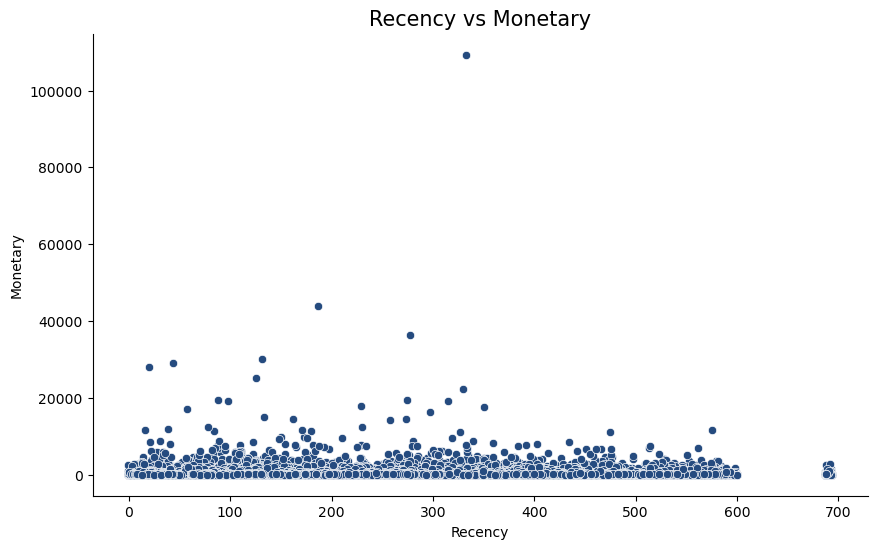

In [82]:
plt.figure(figsize= [10, 6])
sns.scatterplot(x= 'Recency',y= 'Monetary', data=rfm_table)
plt.title('Recency vs Monetary', fontsize= 15)
sns.despine()

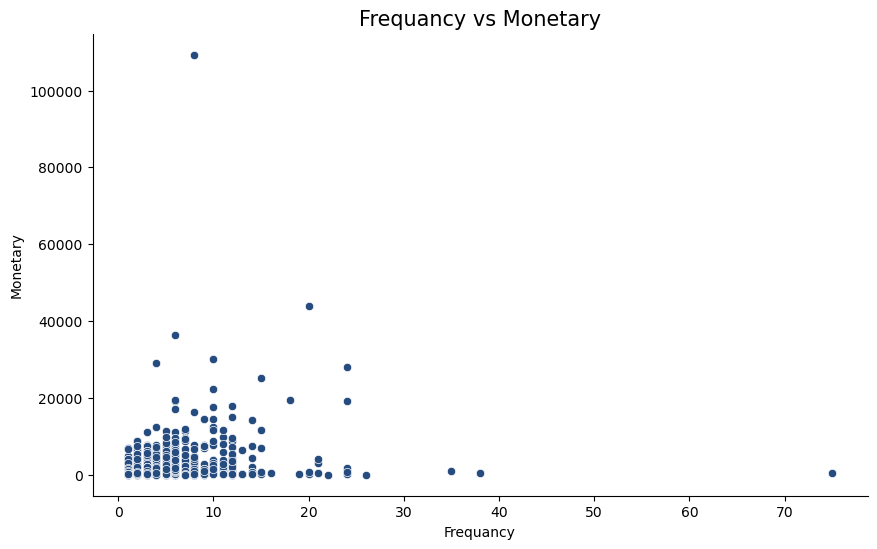

In [83]:
plt.figure(figsize= [10, 6])
sns.scatterplot(x='Frequancy', y='Monetary', data=rfm_table)
plt.title('Frequancy vs Monetary', fontsize= 15)
sns.despine()

In [84]:
# Calculate RFM Score
rfm_table['rfm_score'] = 100 * rfm_table['r_score'].astype(int) + 10 * rfm_table['f_score'].astype(int)+ rfm_table['m_score'].astype(int)
rfm_table

Recency  Frequancy  Monetary r_score  \
customer_unique_id                                                       
0000366f3b9a7992bf8c76cfdf3221e2      110          1    141.90       4   
0000b849f77a49e4a4ce2b2a4ca5be3f      113          1     27.19       3   
0000f46a3911fa3c0805444483337064      536          1     86.22       1   
0000f6ccb0745a6a4b88665a16c9f078      320          1     43.62       2   
0004aac84e0df4da2b147fca70cf8255      287          1    196.89       2   
...                                   ...        ...       ...     ...   
fffcf5a5ff07b0908bd4e2dbc735a684      446          2   4134.84       1   
fffea47cd6d3cc0a88bd621562a9d061      261          1     84.58       2   
ffff371b4d645b6ecea244b27531430a      567          1    112.46       1   
ffff5962728ec6157033ef9805bacc48      118          1    133.69       3   
ffffd2657e2aad2907e67c3e9daecbeb      483          1     71.56       1   

                                 f_score m_score  rfm_score  
customer_unique_id                                           
0000366f3b9a7992bf8c76cfdf3221e2       1       3        413  
0000b849f77a49e4a4ce2b2a4ca5be3f       1       1        311  
0000f46a3911fa3c0805444483337064       1       2        112  
0000f6ccb0745a6a4b88665a16c9f078       1       1        211  
0004aac84e0df4da2b147fca70cf8255       1       3        213  
...                                  ...     ...        ...  
fffcf5a5ff07b0908bd4e2dbc735a684       4       4        144  
fffea47cd6d3cc0a88bd621562a9d061       4       2        242  
ffff371b4d645b6ecea244b27531430a       4       2        142  
ffff5962728ec6157033ef9805bacc48       4       3        343  
ffffd2657e2aad2907e67c3e9daecbeb       4       2        142  

[90986 rows x 7 columns]

In [85]:
# Cluster customers based on RFM Score
def customer_segmenation(rfm_score):
  
  if rfm_score == 444:
    return 'VIP'
  
  elif  rfm_score >= 433 and rfm_score < 444:
    return 'Very Loyal Customer'
  
  elif   rfm_score >=421 and rfm_score< 433:
    return 'Potential Loyalist Customer'
  
  elif rfm_score>=344 and rfm_score < 421:
    return 'New Customer'
  
  elif rfm_score>=323 and rfm_score<344:
    return 'Potential Customer'
  
  elif rfm_score>=224 and rfm_score<311:
    return 'At-Risk Customers' 
  
  else:
    return 'Lost customers'       
  
rfm_table['customer_segmentation'] = rfm_table['rfm_score'].apply(customer_segmenation)

rfm_table

Recency  Frequancy  Monetary r_score  \
customer_unique_id                                                       
0000366f3b9a7992bf8c76cfdf3221e2      110          1    141.90       4   
0000b849f77a49e4a4ce2b2a4ca5be3f      113          1     27.19       3   
0000f46a3911fa3c0805444483337064      536          1     86.22       1   
0000f6ccb0745a6a4b88665a16c9f078      320          1     43.62       2   
0004aac84e0df4da2b147fca70cf8255      287          1    196.89       2   
...                                   ...        ...       ...     ...   
fffcf5a5ff07b0908bd4e2dbc735a684      446          2   4134.84       1   
fffea47cd6d3cc0a88bd621562a9d061      261          1     84.58       2   
ffff371b4d645b6ecea244b27531430a      567          1    112.46       1   
ffff5962728ec6157033ef9805bacc48      118          1    133.69       3   
ffffd2657e2aad2907e67c3e9daecbeb      483          1     71.56       1   

                                 f_score m_score  rfm_score  \
customer_unique_id                                            
0000366f3b9a7992bf8c76cfdf3221e2       1       3        413   
0000b849f77a49e4a4ce2b2a4ca5be3f       1       1        311   
0000f46a3911fa3c0805444483337064       1       2        112   
0000f6ccb0745a6a4b88665a16c9f078       1       1        211   
0004aac84e0df4da2b147fca70cf8255       1       3        213   
...                                  ...     ...        ...   
fffcf5a5ff07b0908bd4e2dbc735a684       4       4        144   
fffea47cd6d3cc0a88bd621562a9d061       4       2        242   
ffff371b4d645b6ecea244b27531430a       4       2        142   
ffff5962728ec6157033ef9805bacc48       4       3        343   
ffffd2657e2aad2907e67c3e9daecbeb       4       2        142   

                                 customer_segmentation  
customer_unique_id                                      
0000366f3b9a7992bf8c76cfdf3221e2          New Customer  
0000b849f77a49e4a4ce2b2a4ca5be3f        Lost customers  
0000f46a3911fa3c0805444483337064        Lost customers  
0000f6ccb0745a6a4b88665a16c9f078        Lost customers  
0004aac84e0df4da2b147fca70cf8255        Lost customers  
...                                                ...  
fffcf5a5ff07b0908bd4e2dbc735a684        Lost customers  
fffea47cd6d3cc0a88bd621562a9d061     At-Risk Customers  
ffff371b4d645b6ecea244b27531430a        Lost customers  
ffff5962728ec6157033ef9805bacc48    Potential Customer  
ffffd2657e2aad2907e67c3e9daecbeb        Lost customers  

[90986 rows x 8 columns]

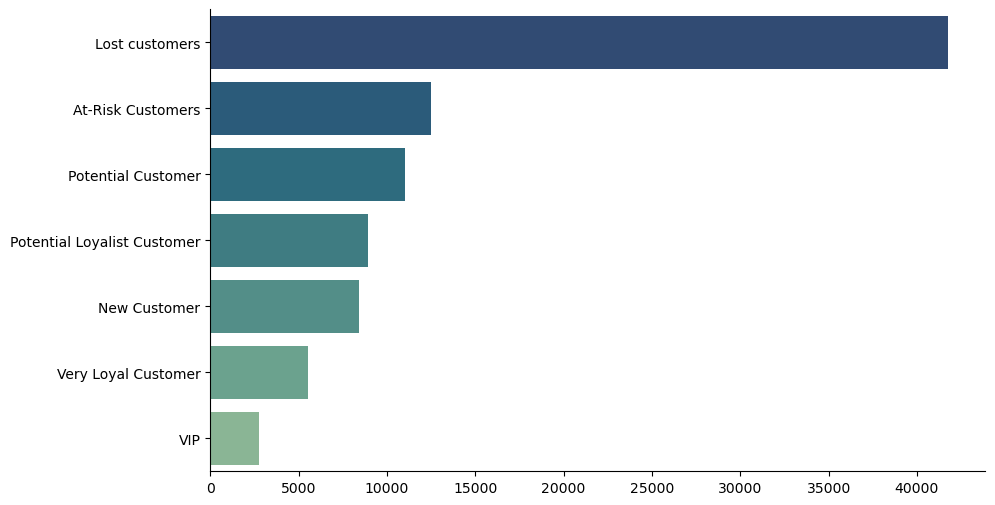

In [86]:
# Plot frquency of each segment
plt.figure(figsize=[10,6])
sns.barplot(x = rfm_table.customer_segmentation.value_counts().values, y= rfm_table.customer_segmentation.value_counts().index, palette= 'crest_r')
sns.despine()

In [87]:
# check outliers

rfm_table.describe()

Recency     Frequancy       Monetary     rfm_score
count  90986.000000  90986.000000   90986.000000  90986.000000
mean     235.125953      1.237036     211.896340    277.953872
std      152.238922      0.843602     632.183713    112.473220
min       -1.000000      1.000000       9.590000    111.000000
25%      112.000000      1.000000      63.680000    211.000000
50%      216.000000      1.000000     112.685000    311.000000
75%      344.000000      1.000000     201.990000    411.000000
max      694.000000     75.000000  109312.640000    444.000000

<AxesSubplot:xlabel='Recency'>

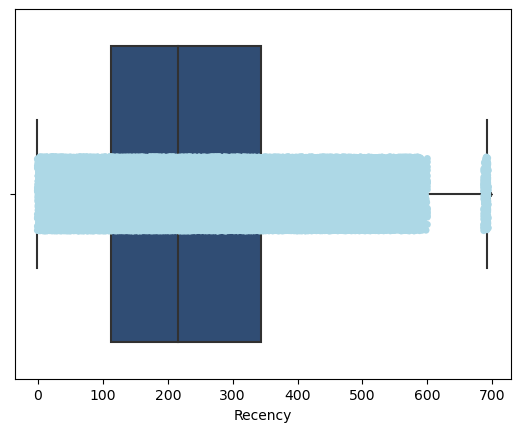

In [88]:
# Recency
sns.boxplot(x= rfm_table.Recency)
sns.stripplot(x = rfm_table.Recency, color= 'lightblue') 

<AxesSubplot:xlabel='Frequancy'>

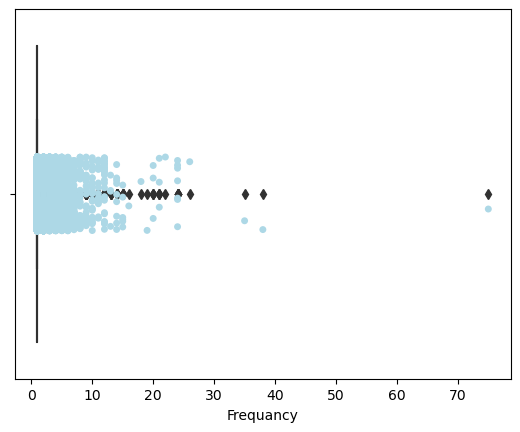

In [89]:
# Frequency
sns.boxplot(x= rfm_table.Frequancy)
sns.stripplot(x = rfm_table.Frequancy, color= 'lightblue')

<AxesSubplot:xlabel='Monetary'>

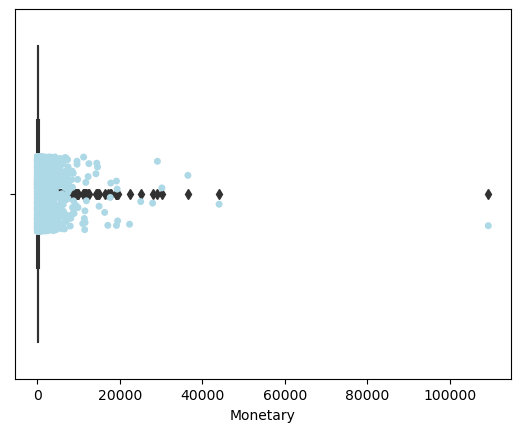

In [90]:
# Monetary 
sns.boxplot(x= rfm_table.Monetary)
sns.stripplot(x = rfm_table.Monetary, color= 'lightblue')

In [91]:
# Remove Extreme 5% of Outliers
print('Recency 5% Outliers Limits:', np.percentile(rfm_table.Recency, 5), np.percentile(rfm_table.Recency, 95))
print('Frequancy 5% Outliers Limits:', np.percentile(rfm_table.Frequancy, 5), np.percentile(rfm_table.Frequancy, 95))
print('Monetary 5% Outliers Limits:', np.percentile(rfm_table.Monetary, 5), np.percentile(rfm_table.Monetary, 95))

Recency 5% Outliers Limits: 22.0 517.0
Frequancy 5% Outliers Limits: 1.0 2.0
Monetary 5% Outliers Limits: 32.69 661.13


In [92]:
# Remove Outliers for Recency & Monetary (Extreme 5%)
for i in [0, 2]:

    outlier_indices = []
    col = rfm_table.columns[i]
    percentile_5 = np.percentile(rfm_table[col], 5)
    percentile_95 = np.percentile(rfm_table[col], 95)
    outlier_indices.append(rfm_table[(rfm_table[col] < percentile_5) | (rfm_table[col] > percentile_95)].index)

rfm_table.drop(outlier_indices[0][:], inplace= True)
rfm_table.reset_index(inplace= True, drop= True)

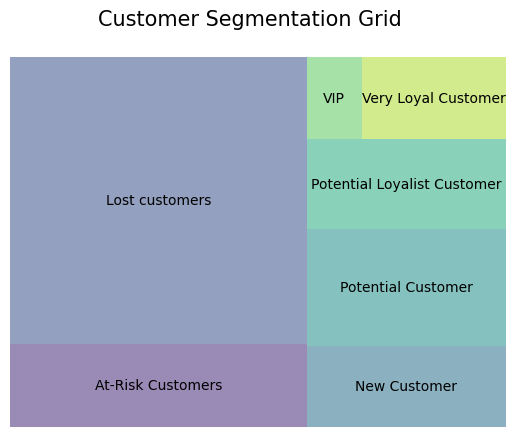

In [93]:
# Customer Segmentation Grid

import squarify
# Assuming Sizes and labels are defined
plt.rc('font', size=10)
Sizes = rfm_table.groupby('customer_segmentation')[['Monetary']].count()

# Choose a color palette
color_palette = sns.color_palette("viridis", n_colors=len(Sizes))

squarify.plot(sizes=Sizes.values, label=Sizes.index, color=color_palette, alpha=.55)
plt.suptitle("Customer Segmentation Grid", fontsize=15)
plt.axis('off')  # Turn off axis labels
plt.show()

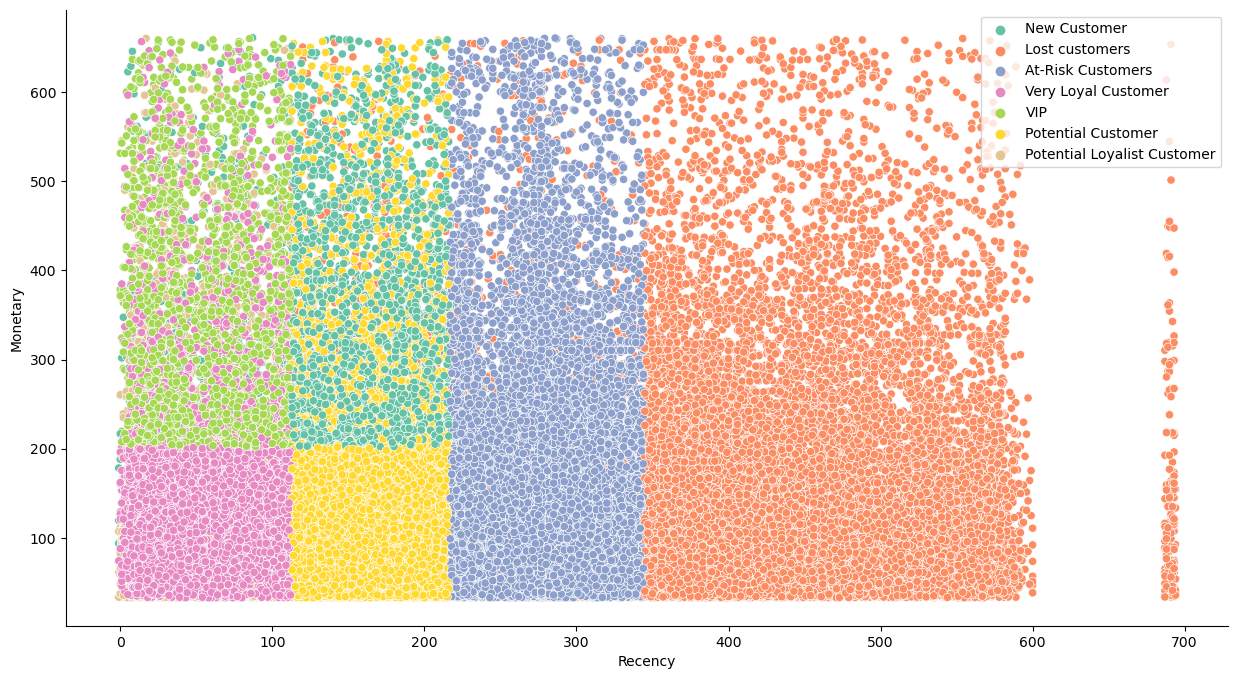

In [94]:
# Recency & Monetary Plot

plt.figure(figsize= [15, 8])
colors = sns.color_palette("Set2", n_colors=len(Sizes))
sns.scatterplot(x= rfm_table.Recency, y= rfm_table.Monetary, hue= rfm_table.customer_segmentation, palette= colors)
plt.legend(prop={'size':10})
sns.despine()

<AxesSubplot:ylabel='Density'>

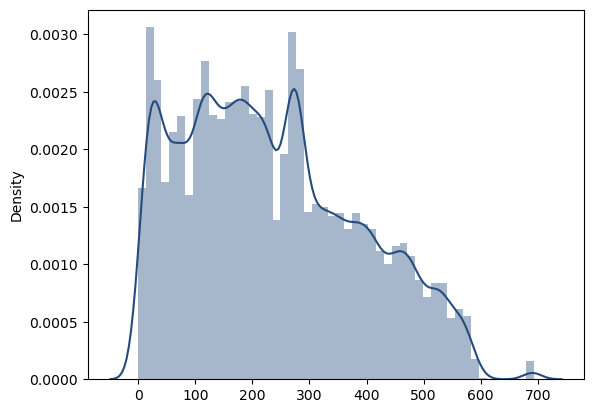

In [95]:
# Check Skeweness

# Recency
sns.distplot(x= rfm_table.Recency)

<AxesSubplot:ylabel='Density'>

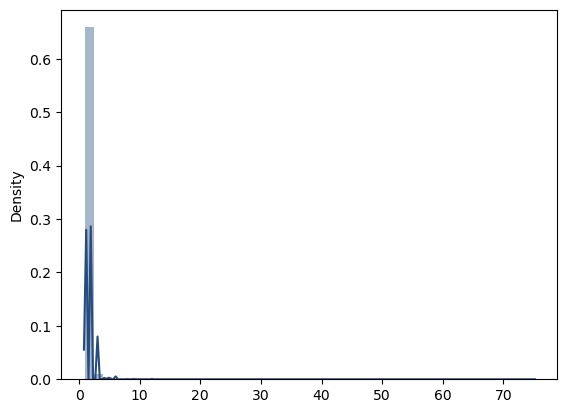

In [96]:
# Frequancy
sns.distplot(x= rfm_table.Frequancy)

<AxesSubplot:ylabel='Density'>

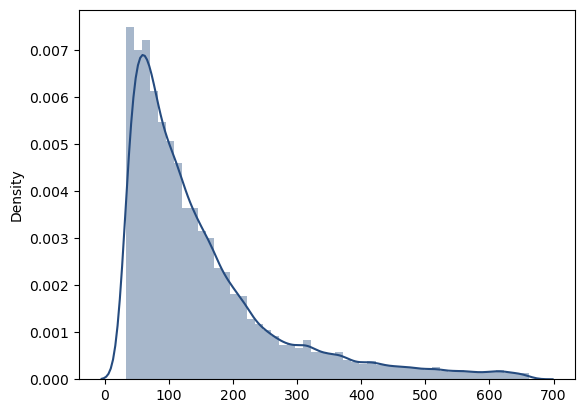

In [97]:
# Monetary
sns.distplot(x= rfm_table.Monetary)

In [98]:
# Apply Log function to handle skeweness for Frequancy & Monetary
for i in ['Frequancy', 'Monetary']:
    rfm_table[i] = np.log10(rfm_table[i])

<AxesSubplot:ylabel='Density'>

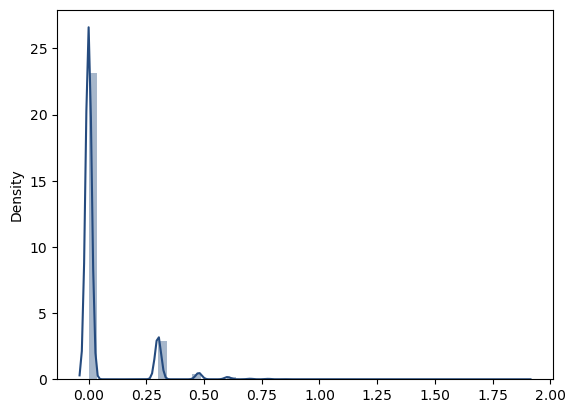

In [99]:
# Frequancy
sns.distplot(x= rfm_table.Frequancy)

<AxesSubplot:ylabel='Density'>

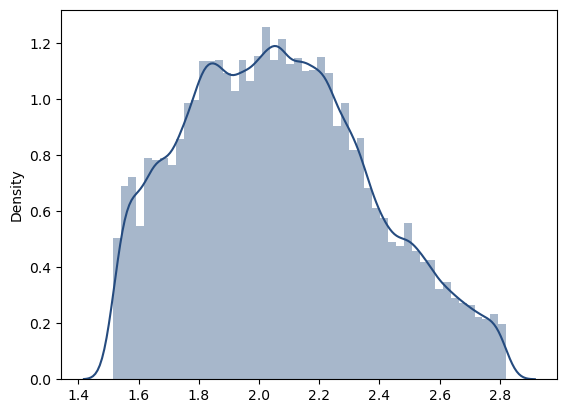

In [100]:
# Monetary
sns.distplot(x= rfm_table.Monetary)

In [101]:
# K-Mean clustering
df_cluster = df2[['freight_value', 'price', 'payment_value', 'payment_installments']]
df_cluster

freight_value   price  payment_value  payment_installments
0               21.88  124.99         146.87                     2
1               24.90  112.99         275.79                     1
2               24.90  112.99         275.79                     1
3               15.62  124.99         140.61                     7
4               30.59  106.99         137.58                    10
...               ...     ...            ...                   ...
112548          15.47  145.90         161.37                     1
112549          22.28   49.90          72.18                     3
112550          88.46  135.98         224.44                     6
112551          31.93  167.99         167.79                     5
112552          31.93  167.99          32.13                     1

[112553 rows x 4 columns]

In [102]:
# Take sample from data (10k)
df_sample = df_cluster.sample(frac= 1, random_state= 42)[:10000]

In [103]:
# Save sample as CSV for deployment

df_sample.to_csv('Clustering_Sample.csv')

In [104]:
df_sample.describe()

freight_value         price  payment_value  payment_installments
count   10000.000000  10000.000000   10000.000000          10000.000000
mean       19.949810    118.104780     168.656074              2.922900
std        16.559843    171.380723     257.185052              2.742391
min         0.000000      2.990000       0.170000              1.000000
25%        13.040000     39.900000      61.000000              1.000000
50%        16.185000     74.990000     106.950000              2.000000
75%        21.150000    130.000000     188.205000              4.000000
max       375.280000   3105.000000   13664.080000             24.000000

In [105]:
# Drop freight values with zeros

df_sample.drop(df_sample[df_sample.freight_value == 0].index, inplace= True)
df_sample.reset_index(inplace= True, drop= True)

In [106]:
# Take copy for Pipeline

cluster_pipeline = df_sample.copy()

for i in ['freight_value', 'price', 'payment_value', 'payment_installments']:
    df_sample[i] = np.log10(df_sample[i])

In [107]:
print(df_sample.isnull().sum())
df_sample.describe()


freight_value           0
price                   0
payment_value           0
payment_installments    0
dtype: int64


freight_value        price  payment_value  payment_installments
count    9959.000000  9959.000000    9959.000000           9959.000000
mean        1.231186     1.871906       2.030808              0.309819
std         0.232803     0.397042       0.410000              0.351974
min        -1.301030     0.475671      -0.769551              0.000000
25%         1.116608     1.600973       1.785294              0.000000
50%         1.210051     1.875003       2.029262              0.301030
75%         1.325310     2.119172       2.274977              0.602060
max         2.574355     3.492062       4.135580              1.380211

In [108]:
# Remove rows with NaN values
df_sample = df_sample.dropna()

# Replace infinite values with a large finite value
df_sample.replace([np.inf, -np.inf], np.nan, inplace=True)
df_sample.fillna(1e10, inplace=True)  # Replace with a large finite value

print(df_sample.max())


freight_value           2.574355
price                   3.492062
payment_value           4.135580
payment_installments    1.380211
dtype: float64


In [109]:
# Feature Scaling

from sklearn.preprocessing import StandardScaler

sc = StandardScaler(with_mean= False)
data_scaled = sc.fit_transform(df_sample)

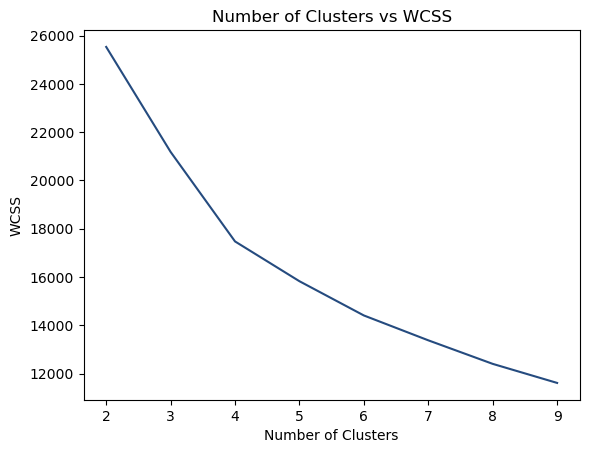

In [125]:
# Detecting number of clusters uning Elbow Method
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
wcss = []
scores = []

for i in range(2, 10):
    kmean = KMeans(n_clusters=i)  
    y_pred_kmean = kmean.fit_predict(data_scaled)
    wcss.append(kmean.inertia_)
    scores.append(silhouette_score(data_scaled, y_pred_kmean))

plt.plot(range(2, 10), wcss)
plt.title('Number of Clusters vs WCSS')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


Text(0, 0.5, 'silhouette_score')

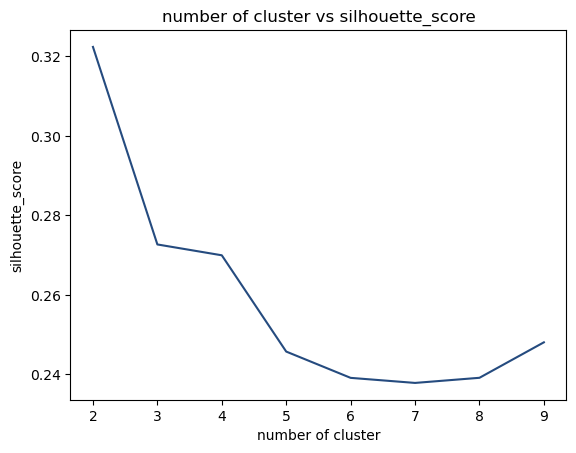

In [126]:
# Detecting number of clusters using Silhouete Score

plt.plot(range(2,10),scores)
plt.title('number of cluster vs silhouette_score')
plt.xlabel('number of cluster')
plt.ylabel('silhouette_score')

In [127]:
# Select number of clusters k= 2
from sklearn.cluster import KMeans

kmean = KMeans(n_clusters= 2)
y_pred_kmean = kmean.fit_predict(data_scaled)


In [128]:
#  Count of each cluster
len(kmean.labels_[kmean.labels_ == 0]), len(kmean.labels_[kmean.labels_ == 1]), len(kmean.labels_[kmean.labels_ == 2])

(4356, 5603, 0)

In [131]:
# Check the length of y_pred_kmean
print(len(y_pred_kmean))

# Check the length of the DataFrame
print(len(original_cluster_sample))


9959
9966


In [132]:
# Take another sample of original cluster dataframe to assign kmeans labels
original_cluster_sample = df_cluster.sample(frac=1, random_state=42)[:len(y_pred_kmean)]

# Assign cluster label to original cluster sample
original_cluster_sample['cluster_label'] = y_pred_kmean
original_cluster_sample.head()

freight_value   price  payment_value  payment_installments  \
45354          21.08   85.00         106.08                    10   
82264          10.96   20.00          30.96                     1   
15888          11.64  144.99         156.63                     3   
93342           7.39   38.00          45.39                     1   
92366          13.53  169.90         183.43                     1   

       cluster_label  
45354              0  
82264              1  
15888              0  
93342              1  
92366              0

In [133]:
original_cluster_sample.groupby('cluster_label').describe().T

cluster_label                          0            1
freight_value        count   4356.000000  5603.000000
                     mean      19.580152    20.232170
                     std       15.514768    17.337454
                     min        0.000000     0.000000
                     25%       12.940000    13.080000
                     50%       16.110000    16.330000
                     75%       20.912500    21.255000
                     max      375.280000   375.280000
price                count   4356.000000  5603.000000
                     mean     119.686194   116.706991
                     std      173.249597   169.631480
                     min        3.850000     2.990000
                     25%       39.900000    39.900000
                     50%       75.000000    74.900000
                     75%      134.900000   129.990000
                     max     2799.650000  3105.000000
payment_value        count   4356.000000  5603.000000
                     mean     171.014979   166.801417
                     std      302.427889   215.868917
                     min        0.270000     0.170000
                     25%       61.037500    61.005000
                     50%      107.780000   106.740000
                     75%      189.287500   187.420000
                     max    13664.080000  3209.720000
payment_installments count   4356.000000  5603.000000
                     mean       2.902893     2.938783
                     std        2.754640     2.733753
                     min        1.000000     1.000000
                     25%        1.000000     1.000000
                     50%        1.000000     2.000000
                     75%        4.000000     4.000000
                     max       24.000000    18.000000

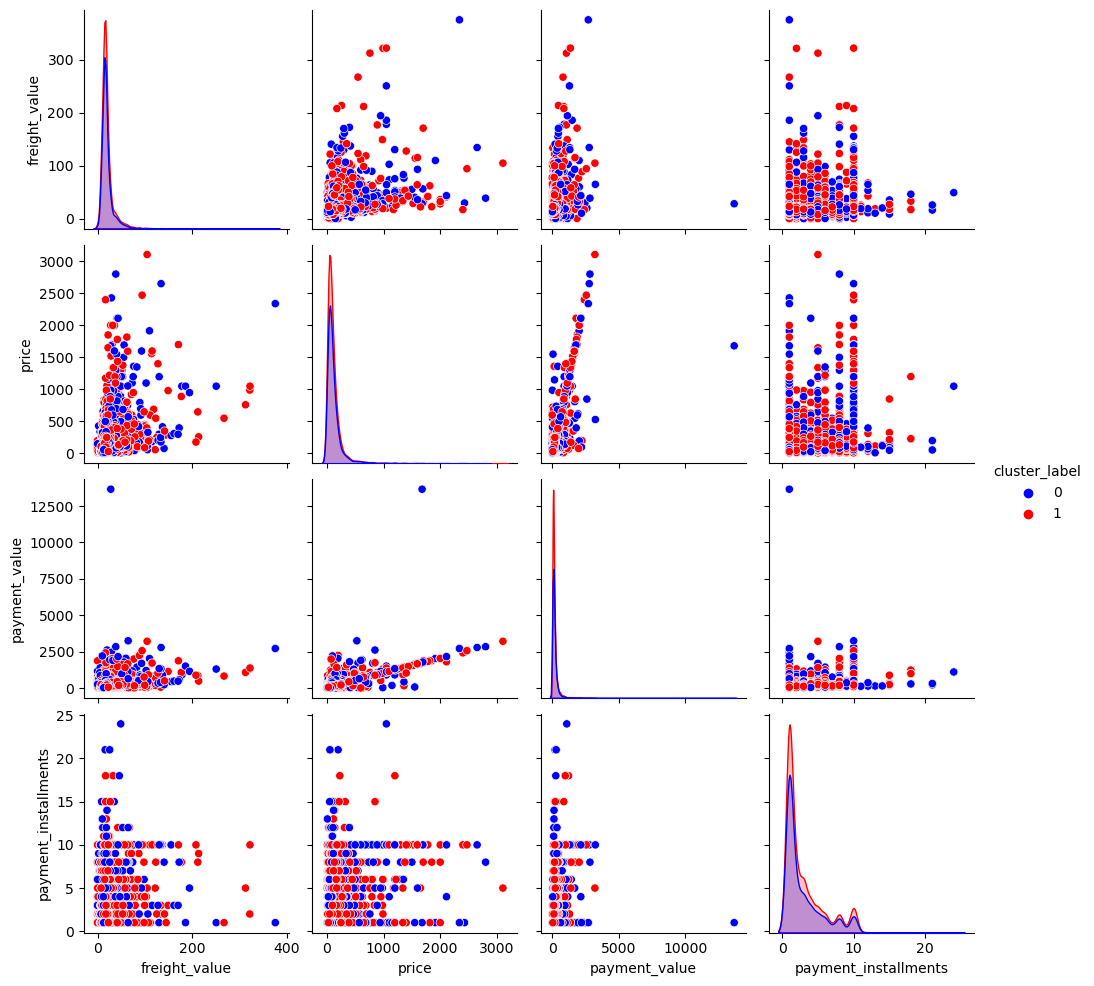

In [135]:
sns.pairplot(data= original_cluster_sample, hue= 'cluster_label', palette= ['blue', 'red'])

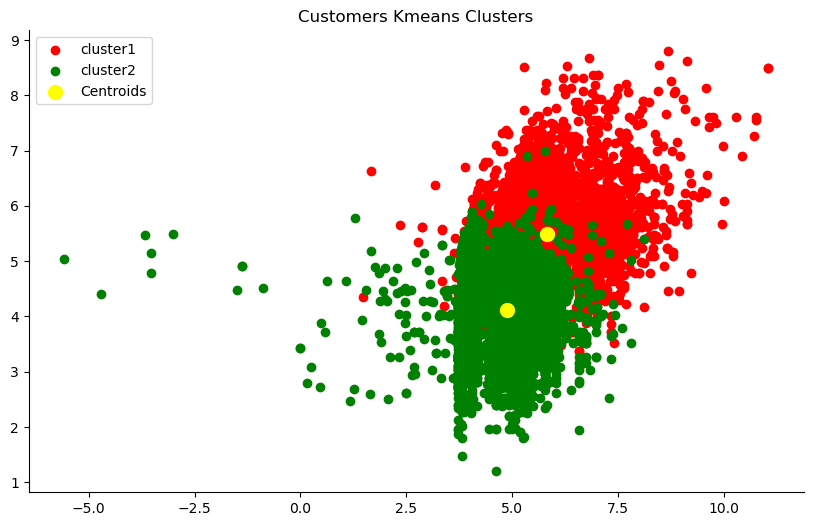

In [137]:
# show k-mean cluster

plt.figure(figsize=[10, 6])
plt.scatter(data_scaled[y_pred_kmean==0,0], data_scaled[y_pred_kmean==0,1], c = 'red',label = 'cluster1')
plt.scatter(data_scaled[y_pred_kmean==1,0], data_scaled[y_pred_kmean==1,1], c = 'green',label = 'cluster2')
plt.scatter(kmean.cluster_centers_[:,0], kmean.cluster_centers_[:,1], c='yellow', s= 100,label= 'Centroids')
plt.title('Customers Kmeans Clusters')
plt.legend()
sns.despine()

In [138]:
# Select number of clusters k= 3
from sklearn.cluster import KMeans

kmean = KMeans(n_clusters= 3)
y_pred_kmean = kmean.fit_predict(data_scaled)


In [139]:
#  Count of each cluster
len(kmean.labels_[kmean.labels_ == 0]), len(kmean.labels_[kmean.labels_ == 1]), len(kmean.labels_[kmean.labels_ == 2])

(3050, 4141, 2768)

In [140]:
# Check the length of y_pred_kmean
print(len(y_pred_kmean))

# Check the length of the DataFrame
print(len(original_cluster_sample))


9959
9959


In [141]:
# Take another sample of original cluster dataframe to assign kmeans labels
original_cluster_sample = df_cluster.sample(frac=1, random_state=42)[:len(y_pred_kmean)]

# Assign cluster label to original cluster sample
original_cluster_sample['cluster_label'] = y_pred_kmean
original_cluster_sample.head()

freight_value   price  payment_value  payment_installments  \
45354          21.08   85.00         106.08                    10   
82264          10.96   20.00          30.96                     1   
15888          11.64  144.99         156.63                     3   
93342           7.39   38.00          45.39                     1   
92366          13.53  169.90         183.43                     1   

       cluster_label  
45354              0  
82264              1  
15888              0  
93342              1  
92366              2

In [142]:
original_cluster_sample.groupby('cluster_label').describe().T

cluster_label                          0            1            2
freight_value        count   3050.000000  4141.000000  2768.000000
                     mean      19.757351    20.395772    19.484530
                     std       16.427505    18.196657    13.944466
                     min        0.000000     0.000000     0.000000
                     25%       12.940000    13.140000    12.970000
                     50%       16.110000    16.420000    16.135000
                     75%       20.817500    21.280000    21.150000
                     max      375.280000   375.280000   250.570000
price                count   3050.000000  4141.000000  2768.000000
                     mean     120.196285   118.526279   114.828880
                     std      179.362044   179.489196   147.779003
                     min        3.850000     2.990000     5.200000
                     25%       39.900000    39.900000    39.990000
                     50%       73.425000    73.400000    77.995000
                     75%      130.000000   129.990000   137.925000
                     max     2799.650000  3105.000000  2428.000000
payment_value        count   3050.000000  4141.000000  2768.000000
                     mean     171.521144   167.981809   166.465835
                     std      329.754039   226.381463   204.452113
                     min        0.240000     0.170000     0.220000
                     25%       61.775000    60.000000    61.745000
                     50%      106.710000   105.260000   110.565000
                     75%      188.595000   184.930000   191.960000
                     max    13664.080000  3209.720000  3242.840000
payment_installments count   3050.000000  4141.000000  2768.000000
                     mean       2.896393     2.926588     2.947254
                     std        2.717801     2.724539     2.797742
                     min        1.000000     1.000000     1.000000
                     25%        1.000000     1.000000     1.000000
                     50%        1.000000     2.000000     2.000000
                     75%        4.000000     4.000000     4.000000
                     max       21.000000    18.000000    24.000000

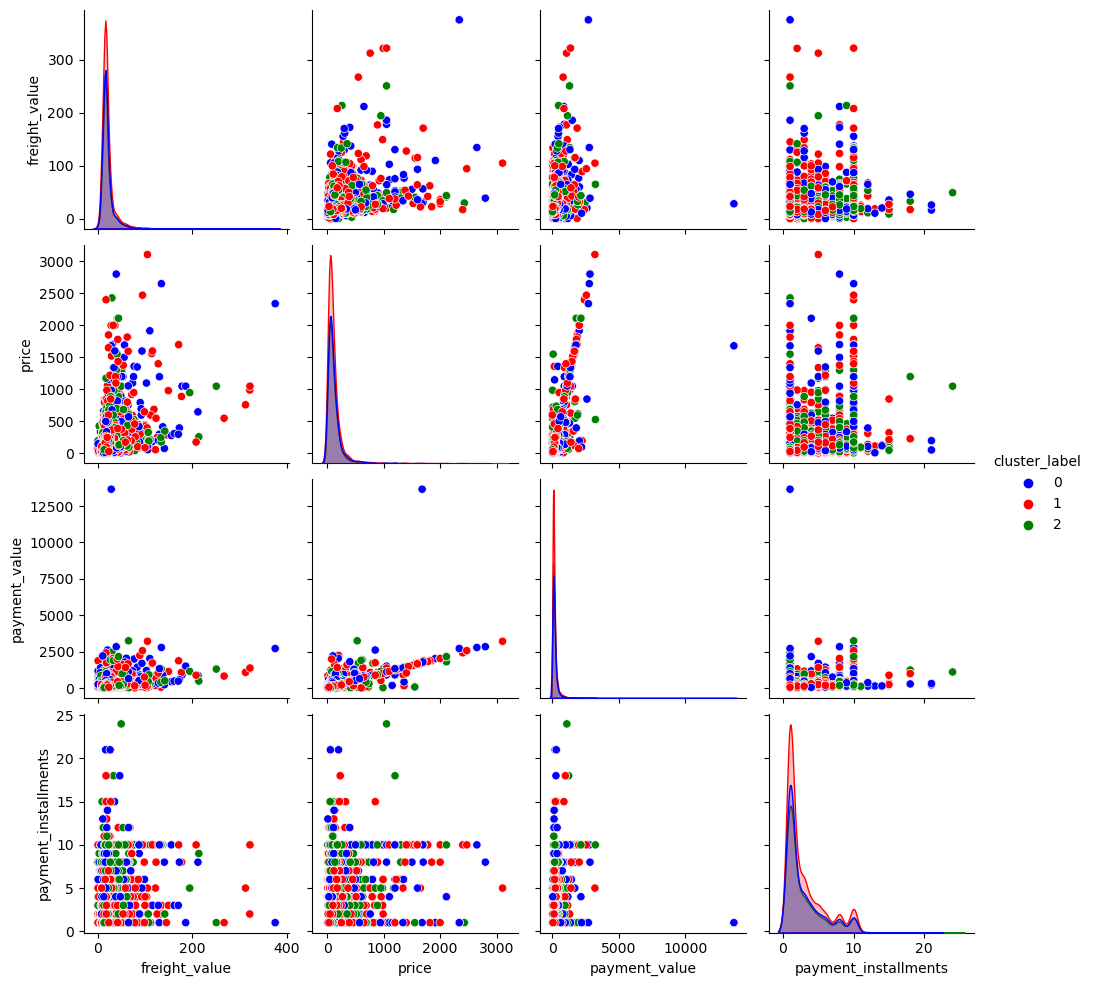

In [144]:
sns.pairplot(data= original_cluster_sample, hue= 'cluster_label', palette= ['blue', 'red','green'])

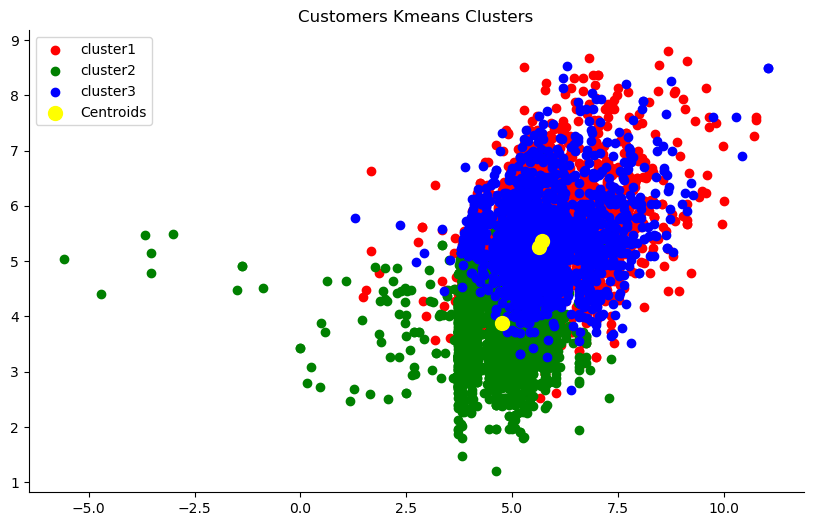

In [145]:
plt.figure(figsize=[10, 6])
plt.scatter(data_scaled[y_pred_kmean==0,0], data_scaled[y_pred_kmean==0,1], c = 'red',label = 'cluster1')
plt.scatter(data_scaled[y_pred_kmean==1,0], data_scaled[y_pred_kmean==1,1], c = 'green',label = 'cluster2')
plt.scatter(data_scaled[y_pred_kmean==2,0], data_scaled[y_pred_kmean==2,1], c = 'blue',label = 'cluster3')
plt.scatter(kmean.cluster_centers_[:,0], kmean.cluster_centers_[:,1], c='yellow', s= 100,label= 'Centroids')
plt.title('Customers Kmeans Clusters')
plt.legend()
sns.despine()

In [146]:
# Select number of clusters k= 4
from sklearn.cluster import KMeans
kmean = KMeans(n_clusters= 4)
y_pred_kmean = kmean.fit_predict(data_scaled)


In [147]:
#  Count of each cluster
len(kmean.labels_[kmean.labels_ == 0]), len(kmean.labels_[kmean.labels_ == 1]), len(kmean.labels_[kmean.labels_ == 2])

(1309, 3101, 3011)

In [148]:
# Check the length of y_pred_kmean
print(len(y_pred_kmean))

# Check the length of the DataFrame
print(len(original_cluster_sample))


9959
9959


In [149]:
# Take another sample of original cluster dataframe to assign kmeans labels
original_cluster_sample = df_cluster.sample(frac=1, random_state=42)[:len(y_pred_kmean)]

# Assign cluster label to original cluster sample
original_cluster_sample['cluster_label'] = y_pred_kmean
original_cluster_sample.head()

freight_value   price  payment_value  payment_installments  \
45354          21.08   85.00         106.08                    10   
82264          10.96   20.00          30.96                     1   
15888          11.64  144.99         156.63                     3   
93342           7.39   38.00          45.39                     1   
92366          13.53  169.90         183.43                     1   

       cluster_label  
45354              3  
82264              2  
15888              3  
93342              2  
92366              1

In [150]:
original_cluster_sample.groupby('cluster_label').describe().T

cluster_label                         0            1            2  \
freight_value        count  1309.000000  3101.000000  3011.000000   
                     mean     20.104477    19.417949    20.324709   
                     std      14.338816    14.754322    18.287915   
                     min       0.000000     0.000000     0.000000   
                     25%      13.080000    12.930000    13.180000   
                     50%      16.280000    16.160000    16.320000   
                     75%      22.060000    20.910000    21.355000   
                     max     185.730000   312.410000   375.280000   
price                count  1309.000000  3101.000000  3011.000000   
                     mean    121.792383   114.645685   118.972116   
                     std     164.989261   145.625625   179.997054   
                     min       7.900000     5.200000     2.990000   
                     25%      41.800000    42.000000    38.800000   
                     50%      78.000000    77.990000    72.000000   
                     75%     139.900000   135.900000   129.900000   
                     max    2110.000000  2428.000000  2470.500000   
payment_value        count  1309.000000  3101.000000  3011.000000   
                     mean    170.802674   165.637891   165.804357   
                     std     224.373385   198.258191   221.102342   
                     min       0.270000     0.170000     0.260000   
                     25%      61.790000    62.910000    58.590000   
                     50%     109.220000   110.000000   104.700000   
                     75%     191.670000   192.180000   181.535000   
                     max    2607.090000  3242.840000  2713.360000   
payment_installments count  1309.000000  3101.000000  3011.000000   
                     mean      2.907563     2.981941     2.884092   
                     std       2.731319     2.791981     2.695915   
                     min       1.000000     1.000000     1.000000   
                     25%       1.000000     1.000000     1.000000   
                     50%       1.000000     2.000000     2.000000   
                     75%       4.000000     4.000000     4.000000   
                     max      15.000000    24.000000    18.000000   

cluster_label                          3  
freight_value        count   2538.000000  
                     mean      20.064015  
                     std       17.549937  
                     min        0.000000  
                     25%       13.022500  
                     50%       16.110000  
                     75%       20.685000  
                     max      375.280000  
price                count   2538.000000  
                     mean     119.028680  
                     std      191.470355  
                     min        3.850000  
                     25%       39.335000  
                     50%       72.250000  
                     75%      129.900000  
                     max     3105.000000  
payment_value        count   2538.000000  
                     mean     174.574023  
                     std      357.596229  
                     min        0.240000  
                     25%       60.872500  
                     50%      105.915000  
                     75%      188.492500  
                     max    13664.080000  
payment_installments count   2538.000000  
                     mean       2.905437  
                     std        2.743775  
                     min        1.000000  
                     25%        1.000000  
                     50%        1.000000  
                     75%        4.000000  
                     max       21.000000

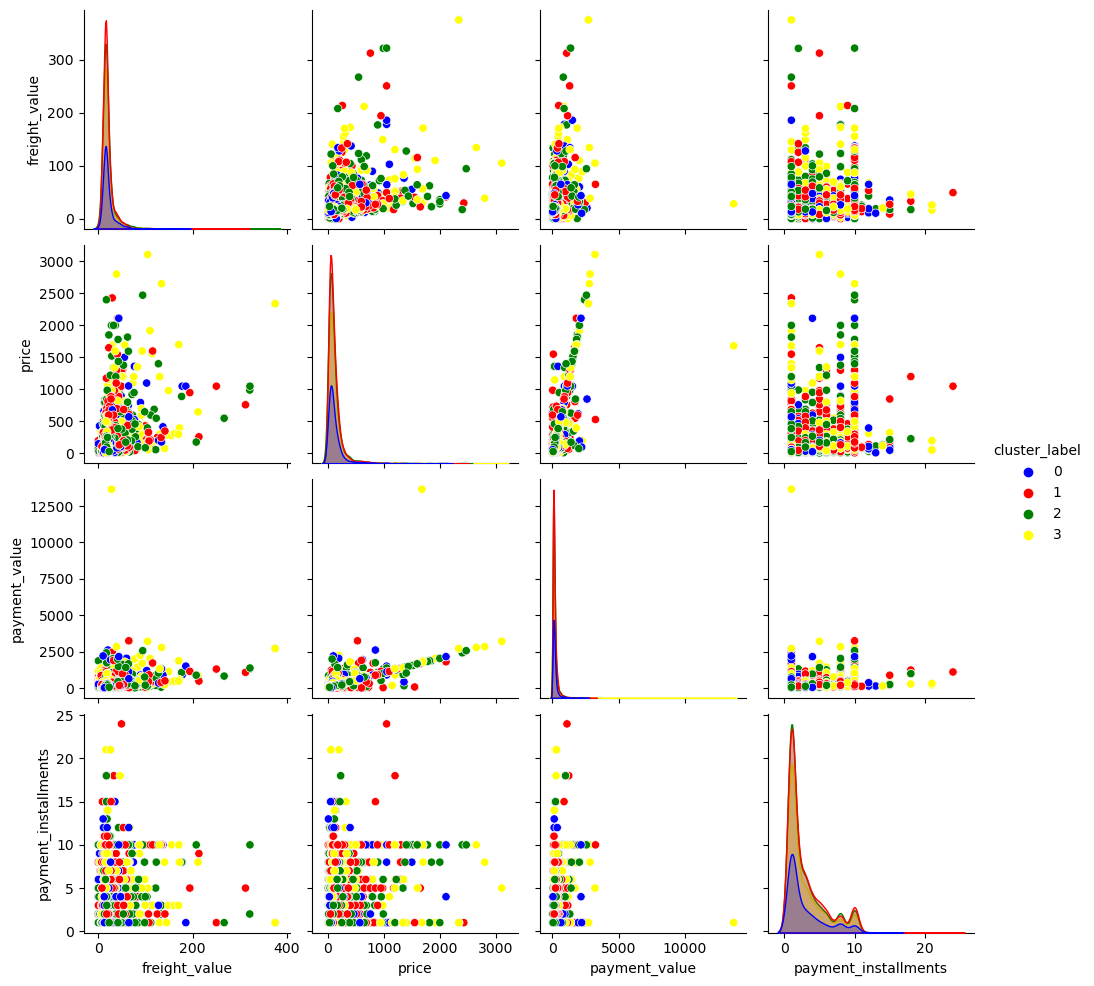

In [151]:
sns.pairplot(data= original_cluster_sample, hue= 'cluster_label', palette= ['blue', 'red','green','yellow'])

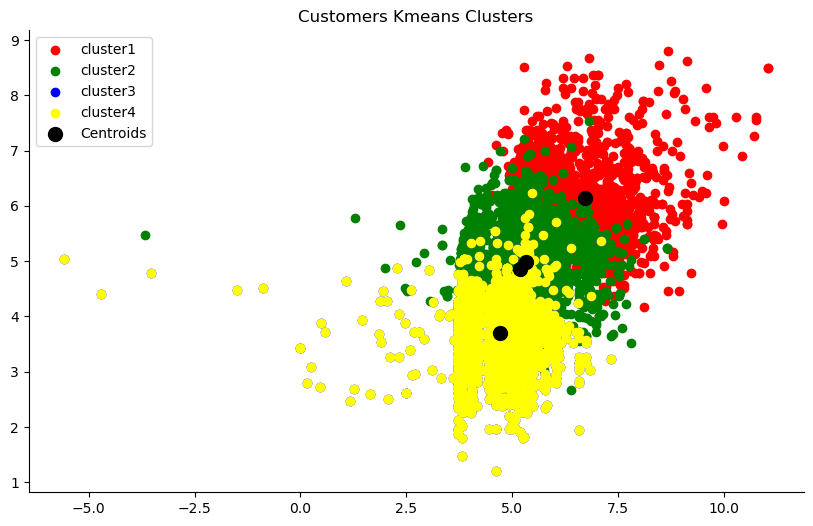

In [152]:
plt.figure(figsize=[10, 6])
plt.scatter(data_scaled[y_pred_kmean==0,0], data_scaled[y_pred_kmean==0,1], c = 'red',label = 'cluster1')
plt.scatter(data_scaled[y_pred_kmean==1,0], data_scaled[y_pred_kmean==1,1], c = 'green',label = 'cluster2')
plt.scatter(data_scaled[y_pred_kmean==2,0], data_scaled[y_pred_kmean==2,1], c = 'blue',label = 'cluster3')
plt.scatter(data_scaled[y_pred_kmean==2,0], data_scaled[y_pred_kmean==2,1], c = 'yellow',label = 'cluster4')
plt.scatter(kmean.cluster_centers_[:,0], kmean.cluster_centers_[:,1], c='black', s= 100,label= 'Centroids')
plt.title('Customers Kmeans Clusters')
plt.legend()
sns.despine()

In [111]:
# # merge data to carry out the objective
# # Create a feature representing the number of times a customer has purchased a specific product
# repeat_purchase = df.groupby(['customer_id', 'product_id']).size().reset_index(name='purchase_count')

# # Define criteria for repeat customers (e.g., purchase_count > 1)
# repeat_customers = repeat_purchase[repeat_purchase['purchase_count'] > 1]

In [112]:
# repeat_purchase

In [113]:
# repeat_customers

NameError: name 'repeat_customers' is not defined

In [ ]:
# # Data preparation for neural network
# X = repeat_customers.drop(columns=['purchase_count'])
# y = repeat_customers['purchase_count']

# # Encode categorical variables (if needed)
# X_encoded = pd.get_dummies(X, columns=['customer_id', 'product_id'])

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# # Standardize the input data (if needed)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)


In [ ]:
# # Build a simple neural network model
# model = keras.Sequential([
#     keras.layers.Input(shape=(X_train.shape[1],)),
#     keras.layers.Dense(64, activation='relu'),
#     keras.layers.Dense(1, activation='sigmoid')
# ])

In [ ]:
# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Train the neural network
# model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# # Evaluate the model
# test_loss, test_acc = model.evaluate(X_test, y_test)
# print(f"Test accuracy: {test_acc}")

# # Interpret results and insights
# # You can use the model to predict repeat customer behavior based on customer and product features.

In [ ]:
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.legend()
# plt.title('Loss Curves')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.show()

In [ ]:
# # Data preparation for neural network
# X = repeat_customers.drop(columns=['purchase_count'])
# y = repeat_customers['purchase_count']

In [ ]:
# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Standardize the input features
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# # Define your model architecture
# model = keras.Sequential([
#     keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
#     keras.layers.Dropout(0.2),  # Dropout layer for regularization
#     keras.layers.Dense(32, activation='relu'),
#     keras.layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
# ])

# # Compile the model with binary cross-entropy loss and an appropriate optimizer
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Train the model with early stopping to prevent overfitting
# early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping])

# # Evaluate the model
# test_loss, test_accuracy = model.evaluate(X_test, y_test)
# print(f"Test accuracy: {test_accuracy}")

# # Plot training and validation curves for loss and accuracy (optional)
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.legend()
# plt.title('Loss Curves')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.show()

In [ ]:
# # EDA after merged data
# # Distribution of the number of orders per customer
# order_counts = df['customer_id'].value_counts()
# plt.hist(order_counts, bins=35)
# plt.title('Distribution of Number of Orders per Customer')
# plt.xlabel('Number of Orders')
# plt.ylabel('Number of Customers')
# plt.show()

# # Products bought more than once
# repeat_purchases = df.groupby('product_category_name')['order_id'].nunique().sort_values(ascending=False)
# top_categories = repeat_purchases.head(10)
# top_categories.plot(kind='bar')
# plt.title('Top Product Categories Bought More Than Once')
# plt.xlabel('Product Category')
# plt.ylabel('Number of Orders')
# plt.show()

In [ ]:
# # Descriptive Statistics
# # Customers making repeat purchases
# repeat_purchase = df.groupby(['customer_id', 'product_id']).size().reset_index(name='purchase_count')
# repeat_customers = repeat_purchase[repeat_purchase['purchase_count'] > 1]
# repeat_customers


In [ ]:
# # Group by 'customer_id' and calculate the total purchase count for each customer
# customer_repeat_purchase = repeat_customers.groupby('customer_id')['purchase_count'].sum().reset_index(name='total_purchase_count')

# # Sort the DataFrame in descending order based on the total purchase count
# customer_repeat_purchase = customer_repeat_purchase.sort_values(by='total_purchase_count', ascending=False)

# # Display the customers with the highest repeat purchases
# top_repeat_customers = customer_repeat_purchase.head(30)  
# top_repeat_customers

In [ ]:
# # Compute the average price for each product
# avg_price_per_product = df.groupby('product_id')['price'].mean().reset_index(name='average_price')

# # Compute the number of times each product was purchased by each customer
# repeat_purchase = df.groupby(['customer_id', 'product_id']).size().reset_index(name='purchase_count')

# # Merge the datasets to correlate purchase counts with product prices
# product_data = repeat_purchase.merge(avg_price_per_product, on='product_id')

# product_data

In [ ]:
# product_data.describe()

In [ ]:
# repeat_purchase = df.groupby(['customer_id', 'product_id']).size().reset_index(name='purchase_count')

In [ ]:
# repeat_purchase

In [ ]:
# # Mean and median purchase counts
# mean_purchase_count = repeat_purchase['purchase_count'].mean()
# median_purchase_count = repeat_purchase['purchase_count'].median()

# # Customers with the highest repeat purchases
# top_repeat_customers = repeat_purchase.sort_values(by='purchase_count', ascending=False).head(10)

# # Visualization of the distribution of purchase counts
# import matplotlib.pyplot as plt
# plt.hist(repeat_purchase['purchase_count'], bins=20, range=(1, 20))
# plt.xlabel('Purchase Count')
# plt.ylabel('Frequency')
# plt.title('Distribution of Purchase Counts')
# plt.show()
